# Data Food Classification Project
### By Mariia Verbytska, 2025
### Data can be found [here](https://huggingface.co/datasets/Kaludi/data-food-classification)
#### Mapping of class label – actual name:
0: *apple_pie*

1: *falafel*

2: *french_toast*

3: *ice_cream*

4: *ramen*

5: *sushi*

6: *tiramisu*

#### All trained models are listed in the **models** section of this repo.

#### Necessary modules installation

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install datasets torchmetrics torchsummary

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
from torchsummary import summary
from torch.optim import lr_scheduler
import pickle
import sys
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import inspect
from tqdm import tqdm
from datasets import load_dataset
import warnings
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", message=".*Truncated File Read.*")

ds = load_dataset('Kaludi/data-food-classification')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
plt.style.use('ggplot')

## **Part 1:** EDA

#### Dataset structure understanding

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1050
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 350
    })
})


In [ ]:
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['validation'])

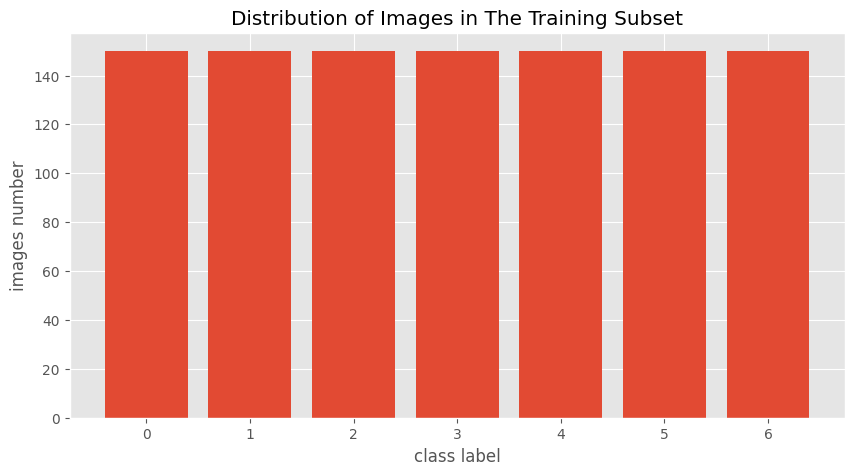

In [ ]:
label_counts = train_df['label'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('class label')
plt.ylabel('images number')
plt.title('Distribution of Images in The Training Subset')
plt.show()

**Conclusions:**

The dataset contains 6 classes. By the diagram of the class distribution we see that data is balanced as the number of samples for each class is equal.

#### Print the mapping between class labels and actual product names

In [ ]:
label_names = ds['train'].features['label'].names

label_mapping = {i: name for i, name in enumerate(label_names)}
print(label_mapping)

{0: 'apple_pie', 1: 'falafel', 2: 'french_toast', 3: 'ice_cream', 4: 'ramen', 5: 'sushi', 6: 'tiramisu'}


#### Print the member of each class

In [ ]:
def get_sample_images_by_category(hf_dataset):
    samples = {}
    label_names = hf_dataset.features['label'].names

    for label in range(len(label_names)):
        for item in hf_dataset:
            if item['label'] == label:
                samples[label_names[label]] = item['image']
                break
    return samples

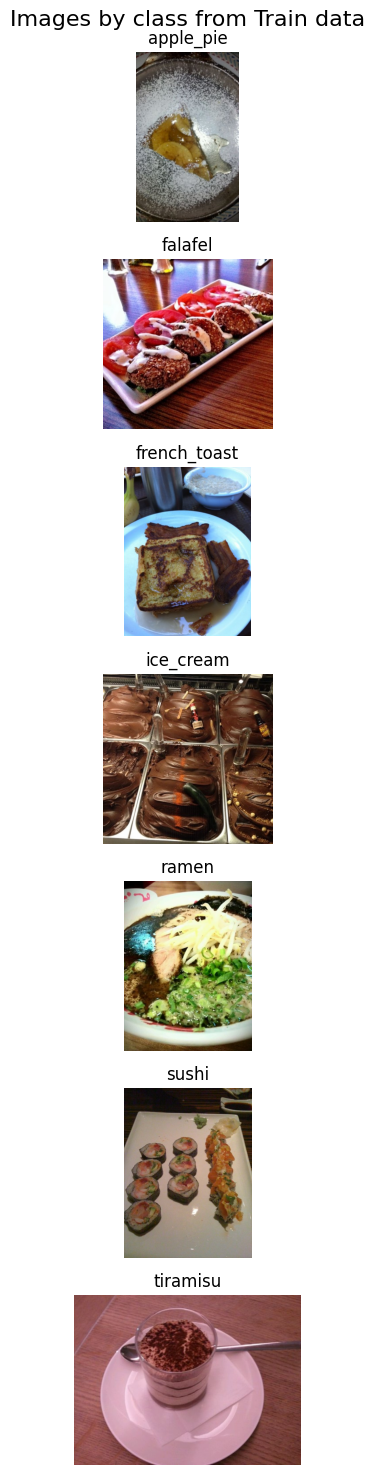

In [ ]:
sample_images = get_sample_images_by_category(ds['train'])
fig, axes = plt.subplots(len(sample_images), 1, figsize=(5, 15))


for ax, (category_name, img) in zip(axes, sample_images.items()):
    ax.imshow(img)
    ax.set_title(category_name, fontsize=12)
    ax.axis('off')

plt.suptitle('Images by сlass from Train data', fontsize=16)
plt.tight_layout()
plt.show()

#### Plot the count of images by class for train and validation data subsets

In [ ]:
num_classes = len(label_names)
def count_labels(split):
    labels = [item['label'] for item in ds[split]]
    counts = pd.Series(labels).value_counts().sort_index()
    return counts

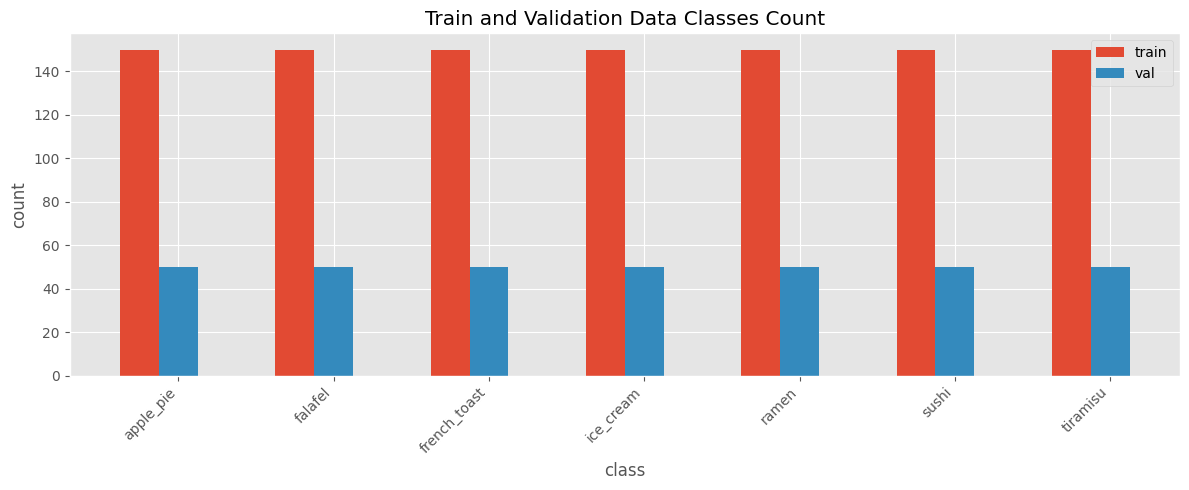

In [ ]:
train_counts = count_labels('train')
val_counts = count_labels('validation')

x = np.arange(len(label_names))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 5))
rects1 = ax.bar(x - width, train_counts.values, width, label='train')
rects2 = ax.bar(x, val_counts.values, width, label='val')

ax.set_xlabel('class')
ax.set_ylabel('count')
ax.set_title('Train and Validation Data Classes Count')
ax.set_xticks(x)
ax.set_xticklabels(label_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

**Conclusions:**

For both train and validation subsets the data is balanced as these sets have an equal number of samples for each class

#### Plot the sizes of images distribution within the train subset

In [ ]:
def get_image_sizes(dataset):
    sizes = []
    for item in dataset:
        image = item['image']
        width, height = image.size
        sizes.append((width, height))
    return sizes

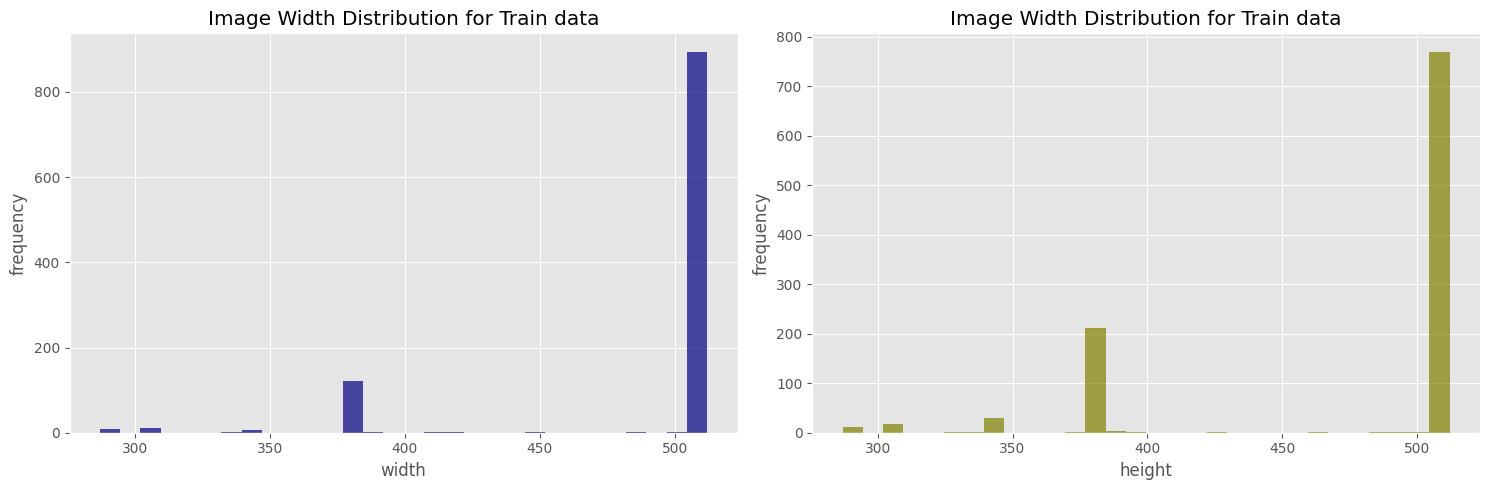

In [ ]:
train_sizes = get_image_sizes(ds['train'])

train_widths, train_heights = zip(*train_sizes)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_widths, bins=30, alpha=0.7, color='navy')
axes[0].set_title('Image Width Distribution for Train data')
axes[0].set_xlabel('width')
axes[0].set_ylabel('frequency')

axes[1].hist(train_heights, bins=30, alpha=0.7, color='olive')
axes[1].set_title('Image Width Distribution for Train data')
axes[1].set_xlabel('height')
axes[1].set_ylabel('frequency')

plt.tight_layout()
plt.show()

**Conclusions:**

From image width and height distribution plots we see that most images have the size of 500x500, but there are still exist some of the size between 350-400 pixels. This leads us to an insight that resizing is crucial here.

#### Plot the brightness distribution within the train subset

In [ ]:
def calculate_brightness(image):
    grayscale_image = image.convert('L')
    np_image = np.array(grayscale_image)
    return np.mean(np_image)

In [ ]:
brightness_values = []

for item in ds['train']:
    image = item['image']

    brightness = calculate_brightness(image)
    brightness_values.append(brightness)
    brightness = calculate_brightness(image)
    brightness_values.append(brightness)

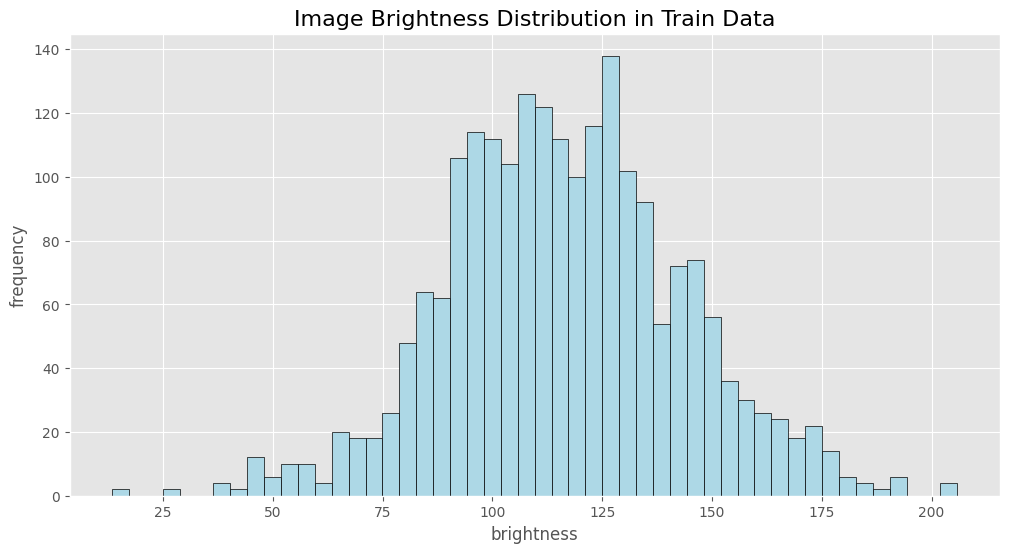

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(brightness_values, bins=50, color='lightblue', edgecolor='black')
plt.title('Image Brightness Distribution in Train Data', fontsize=16)
plt.xlabel('brightness')
plt.ylabel('frequency')
plt.show()

**Conclusion:**

The brightness of images in train data seems to follow a normal distribution. Therefore, we may consider applying ColorJitter in transforms definition step as it should not effect the data in a poor way but improve the model's ability to generalise.

## **Part 2:** Data Loaders Definition & Basic Modeling

#### Define the custom dataset to work with it further

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

#### Determine on a size of testing data (10% of originally train subset)

In [ ]:
split_ds = ds['train'].train_test_split(test_size=0.1, seed=42)

#### Get the number of images of each class within each of used subsets

In [ ]:
from collections import Counter
def count_images_per_class(dataset):
    labels = [item['label'] for item in dataset]
    label_counts = Counter(labels)
    return label_counts

In [ ]:
train_counts = count_images_per_class(split_ds['train'])
val_counts = count_images_per_class(ds['validation'])
test_counts = count_images_per_class(split_ds['test'])

all_classes = set(train_counts.keys()).union(val_counts.keys()).union(test_counts.keys())

for class_label in all_classes:
    class_name = label_mapping.get(class_label)

    train_count = train_counts.get(class_label, 0)
    val_count = val_counts.get(class_label, 0)
    test_count = test_counts.get(class_label, 0)

    print(f'{class_name}: {train_count}, {val_count}, {test_count}')

apple_pie: 135, 50, 15
falafel: 134, 50, 16
french_toast: 133, 50, 17
ice_cream: 133, 50, 17
ramen: 142, 50, 8
sushi: 132, 50, 18
tiramisu: 136, 50, 14


#### Define transformations
* For all subsets:
  * Resizing to 150x150 pixels
  * To tensor conversion
  * Normalization
* For train:
  * Horizontal flip
  * Rotation
  * Color Jitter


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#### Create datasets

In [ ]:
train_dataset = FoodDataset(split_ds['train'], transform=train_transforms)
val_dataset = FoodDataset(ds['validation'], transform=val_transforms)
test_dataset = FoodDataset(split_ds['test'], transform=test_transforms)

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(945, 350, 105)

#### Define the dataloaders using our custom datasets

In [ ]:
batch_size = 64

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

#### Get the first (random) image from a train data loader

In [ ]:
image, label = next(iter(train_loader))

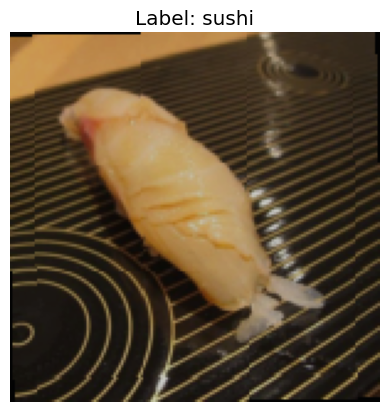

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

image = image[0].float()

image = image.permute(1, 2, 0)
image = image * std + mean

image = image.numpy()

category_name = train_loader.dataset.dataset.features['label'].int2str(label[0].item())

plt.imshow(image)
plt.axis('off')
plt.title(f'Label: {category_name}')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
    return data[0].to(device), data[1].to(device)

#### Basic CNN model architecture
* 3 convolutional layers
* kernel size of 3
* Batch norm used for each layer
* Global Average Pooling
* Dropouts used for both convolutional and fully connected layers
* Max Pooling in a forward step
* Leaky ReLU instead of a regular ReLU

In [ ]:
class BasicCNN(nn.Module):
  """
  Basic CNN architecture.
  """
  def __init__(self, num_classes=7):
    super(BasicCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu1 = nn.LeakyReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.relu2 = nn.LeakyReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.relu3 = nn.LeakyReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dropout_conv = nn.Dropout2d(0.2)

    self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    self.fc1 = nn.Linear(256, 128)
    self.dropout_fc = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.maxpool3(self.relu3(self.bn3(self.conv3(x))))

    x = self.dropout_conv(x)

    x = self.global_avg_pool(x)
    x = x.view(x.size(0), -1)

    x = F.leaky_relu(self.fc1(x))
    x = self.dropout_fc(x)
    x = self.fc2(x)

    return x

In [ ]:
basic_cnn = BasicCNN()
basic_cnn.to(device)

BasicCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv): Dropout2d(p=0.2, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output

#### Model's architecture table

In [ ]:
summary(basic_cnn, input_size=(3, 150, 150), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
       BatchNorm2d-2         [-1, 64, 150, 150]             128
         LeakyReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5          [-1, 128, 75, 75]          73,856
       BatchNorm2d-6          [-1, 128, 75, 75]             256
         LeakyReLU-7          [-1, 128, 75, 75]               0
         MaxPool2d-8          [-1, 128, 37, 37]               0
            Conv2d-9          [-1, 256, 37, 37]         295,168
      BatchNorm2d-10          [-1, 256, 37, 37]             512
        LeakyReLU-11          [-1, 256, 37, 37]               0
        MaxPool2d-12          [-1, 256, 18, 18]               0
        Dropout2d-13          [-1, 256, 18, 18]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Train & Validation functions definition

In [ ]:
def train(model, train_loader, criterion, optimizer, learn_scheduler, device, num_classes=7):
  """
  Trains the model for 1 full epoch, computes the loss and metrics, and returns them all.
  """
    model.train()

    running_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    for inputs, labels in train_loader:
        inputs, labels = to_device((inputs, labels), device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        acc_metric.update(predicted, labels)
        f1_metric.update(predicted, labels)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = acc_metric.compute().item()
    epoch_f1 = f1_metric.compute().item()

    acc_metric.reset()
    f1_metric.reset()

    learn_scheduler.step(epoch_loss)

    return epoch_loss, epoch_acc, epoch_f1, optimizer.param_groups[0]['lr']

In [ ]:
def validate(model, val_loader, criterion, device, num_classes=7):
  """
  Evaluate the model on a validation set after 1 training epoch.
  Computes the validation loss and metrics and returns them all.
  """
    model.eval()

    val_loss = 0.0
    acc_metric = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = to_device((inputs, labels), device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            acc_metric.update(predicted, labels)
            f1_metric.update(predicted, labels)

    val_loss /= len(val_loader)
    val_acc = acc_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    acc_metric.reset()
    f1_metric.reset()

    return val_loss, val_acc, val_f1

In [ ]:
def train_and_eval(model, train_loader, val_loader, criterion, optimizer, learn_scheduler, device, patience=8, num_epochs=50, num_classes=7, save_path=None):
  """
  The loop for the model training and validation for a specified number of epochs.
  Tracking the loss & metrics.
  Saving the best model in a specified location.
  """
    best_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []

    for epoch in tqdm(range(num_epochs), desc='Training'):
        train_loss, train_acc, train_f1, lr = train(model, train_loader, criterion, optimizer, learn_scheduler, device, num_classes)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device, num_classes)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        print(f'\nEpoch: {epoch+1:3}/{num_epochs}, lr: {lr:.6f}, train loss: {train_loss:}, val loss: {val_loss}')
        print(f'train acc: {train_acc}, val acc: {val_acc}')
        print(f'train f1: {train_f1}, val f1: {val_f1}')

        if val_loss < best_loss:
            print(f'val loss decreased: {best_loss} ---> {val_loss}')
            best_loss = val_loss
            epochs_no_improve = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s

### **Experiment 1:** Basic CNN for 70 training epochs

In [ ]:
cnn_optimizer = optim.AdamW(basic_cnn.parameters(), lr=1e-4, weight_decay=1e-4)
cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, mode='min', factor=0.5, patience=3)
cnn_criterion = nn.CrossEntropyLoss()

models_dir = ''
cnn_save_path = os.path.join(models_dir, 'basic_cnn_best.pth')

train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_and_eval(basic_cnn,
                                                                                    train_loader,
                                                                                    val_loader,
                                                                                    cnn_criterion,
                                                                                    cnn_optimizer,
                                                                                    cnn_scheduler,
                                                                                    device,
                                                                                    num_epochs=70,
                                                                                    save_path=cnn_save_path)

Training:   1%|▏         | 1/70 [00:10<11:48, 10.27s/it]


Epoch:   1/70, lr: 0.000100, train loss: 1.9616356213887534, val loss: 1.936359961827596
train acc: 0.14818628132343292, val acc: 0.16285714507102966
train f1: 0.13596613705158234, val f1: 0.08368334174156189
val loss decreased: inf ---> 1.936359961827596


Training:   3%|▎         | 2/70 [00:18<10:27,  9.23s/it]


Epoch:   2/70, lr: 0.000100, train loss: 1.9145801305770873, val loss: 1.9067338307698567
train acc: 0.18051303923130035, val acc: 0.25999999046325684
train f1: 0.17903035879135132, val f1: 0.17471881210803986
val loss decreased: 1.936359961827596 ---> 1.9067338307698567


Training:   4%|▍         | 3/70 [00:29<10:51,  9.72s/it]


Epoch:   3/70, lr: 0.000100, train loss: 1.8834880113601684, val loss: 1.8664607604344685
train acc: 0.23842447996139526, val acc: 0.27714288234710693
train f1: 0.2247052639722824, val f1: 0.21188831329345703
val loss decreased: 1.9067338307698567 ---> 1.8664607604344685


Training:   6%|▌         | 4/70 [00:40<11:28, 10.43s/it]


Epoch:   4/70, lr: 0.000100, train loss: 1.8830204248428344, val loss: 1.8447869618733723
train acc: 0.2348444163799286, val acc: 0.3028571307659149
train f1: 0.22544193267822266, val f1: 0.26298272609710693
val loss decreased: 1.8664607604344685 ---> 1.8447869618733723


Training:   7%|▋         | 5/70 [00:49<10:42,  9.89s/it]


Epoch:   5/70, lr: 0.000100, train loss: 1.848508890469869, val loss: 1.826874574025472
train acc: 0.268928587436676, val acc: 0.2914285659790039
train f1: 0.2574082016944885, val f1: 0.2530037462711334
val loss decreased: 1.8447869618733723 ---> 1.826874574025472


Training:   9%|▊         | 6/70 [00:59<10:29,  9.83s/it]


Epoch:   6/70, lr: 0.000100, train loss: 1.844942855834961, val loss: 1.8168310324350994
train acc: 0.2451838254928589, val acc: 0.28857144713401794
train f1: 0.23481902480125427, val f1: 0.2443724423646927
val loss decreased: 1.826874574025472 ---> 1.8168310324350994


Training:  10%|█         | 7/70 [01:09<10:24,  9.91s/it]


Epoch:   7/70, lr: 0.000100, train loss: 1.8258543332417807, val loss: 1.8080672820409138
train acc: 0.28215929865837097, val acc: 0.2971428632736206
train f1: 0.2668379545211792, val f1: 0.2507455348968506
val loss decreased: 1.8168310324350994 ---> 1.8080672820409138


Training:  11%|█▏        | 8/70 [01:18<09:50,  9.52s/it]


Epoch:   8/70, lr: 0.000100, train loss: 1.8069577137629191, val loss: 1.7908454338709514
train acc: 0.29965952038764954, val acc: 0.28857141733169556
train f1: 0.28053316473960876, val f1: 0.25020432472229004
val loss decreased: 1.8080672820409138 ---> 1.7908454338709514


Training:  13%|█▎        | 9/70 [01:27<09:44,  9.58s/it]


Epoch:   9/70, lr: 0.000100, train loss: 1.8093549410502117, val loss: 1.7796281576156616
train acc: 0.2974344491958618, val acc: 0.31714287400245667
train f1: 0.2829274535179138, val f1: 0.27534201741218567
val loss decreased: 1.7908454338709514 ---> 1.7796281576156616


Training:  14%|█▍        | 10/70 [01:37<09:44,  9.74s/it]


Epoch:  10/70, lr: 0.000100, train loss: 1.7979638258616129, val loss: 1.7539855639139812
train acc: 0.30201125144958496, val acc: 0.3257142901420593
train f1: 0.2957637310028076, val f1: 0.30421483516693115
val loss decreased: 1.7796281576156616 ---> 1.7539855639139812


Training:  16%|█▌        | 11/70 [01:46<09:08,  9.29s/it]


Epoch:  11/70, lr: 0.000100, train loss: 1.7786311546961466, val loss: 1.7569650808970134
train acc: 0.3128485679626465, val acc: 0.3199999928474426
train f1: 0.3057186007499695, val f1: 0.2970425486564636


Training:  17%|█▋        | 12/70 [01:56<09:14,  9.57s/it]


Epoch:  12/70, lr: 0.000100, train loss: 1.7727388381958007, val loss: 1.7431157032648723
train acc: 0.3191532790660858, val acc: 0.35428571701049805
train f1: 0.30960994958877563, val f1: 0.33208519220352173
val loss decreased: 1.7539855639139812 ---> 1.7431157032648723


Training:  19%|█▊        | 13/70 [02:06<09:14,  9.73s/it]


Epoch:  13/70, lr: 0.000100, train loss: 1.7667982975641887, val loss: 1.734885851542155
train acc: 0.3263290524482727, val acc: 0.33714285492897034
train f1: 0.31638282537460327, val f1: 0.31730973720550537
val loss decreased: 1.7431157032648723 ---> 1.734885851542155


Training:  20%|██        | 14/70 [02:14<08:44,  9.36s/it]


Epoch:  14/70, lr: 0.000100, train loss: 1.7515882015228272, val loss: 1.7271499633789062
train acc: 0.32146456837654114, val acc: 0.3342857360839844
train f1: 0.3148212134838104, val f1: 0.30706918239593506
val loss decreased: 1.734885851542155 ---> 1.7271499633789062


Training:  21%|██▏       | 15/70 [02:25<08:50,  9.64s/it]


Epoch:  15/70, lr: 0.000100, train loss: 1.7547802845637004, val loss: 1.7199966510136921
train acc: 0.3210184574127197, val acc: 0.3399999737739563
train f1: 0.3115052878856659, val f1: 0.3240807056427002
val loss decreased: 1.7271499633789062 ---> 1.7199966510136921


Training:  23%|██▎       | 16/70 [02:35<08:47,  9.78s/it]


Epoch:  16/70, lr: 0.000100, train loss: 1.7378185272216797, val loss: 1.7161588271458943
train acc: 0.3247944712638855, val acc: 0.3514285683631897
train f1: 0.3207519054412842, val f1: 0.3343908488750458
val loss decreased: 1.7199966510136921 ---> 1.7161588271458943


Training:  24%|██▍       | 17/70 [02:43<08:16,  9.36s/it]


Epoch:  17/70, lr: 0.000100, train loss: 1.7343179305394492, val loss: 1.7102941672007244
train acc: 0.331348717212677, val acc: 0.34857141971588135
train f1: 0.3226277828216553, val f1: 0.32866644859313965
val loss decreased: 1.7161588271458943 ---> 1.7102941672007244


Training:  26%|██▌       | 18/70 [02:53<08:17,  9.57s/it]


Epoch:  18/70, lr: 0.000100, train loss: 1.7381096522013346, val loss: 1.6931531429290771
train acc: 0.302052766084671, val acc: 0.34857141971588135
train f1: 0.29637521505355835, val f1: 0.3262631893157959
val loss decreased: 1.7102941672007244 ---> 1.6931531429290771


Training:  27%|██▋       | 19/70 [03:03<08:14,  9.69s/it]


Epoch:  19/70, lr: 0.000100, train loss: 1.7271114269892374, val loss: 1.7252657413482666
train acc: 0.3218817114830017, val acc: 0.331428587436676
train f1: 0.31156522035598755, val f1: 0.30076757073402405


Training:  29%|██▊       | 20/70 [03:11<07:43,  9.27s/it]


Epoch:  20/70, lr: 0.000100, train loss: 1.7262125809987385, val loss: 1.6847775777180989
train acc: 0.3439510464668274, val acc: 0.3571428656578064
train f1: 0.33514493703842163, val f1: 0.34622514247894287
val loss decreased: 1.6931531429290771 ---> 1.6847775777180989


Training:  30%|███       | 21/70 [03:22<07:47,  9.53s/it]


Epoch:  21/70, lr: 0.000100, train loss: 1.6965381224950156, val loss: 1.6762431462605794
train acc: 0.3231012225151062, val acc: 0.37714287638664246
train f1: 0.3171349763870239, val f1: 0.3602639436721802
val loss decreased: 1.6847775777180989 ---> 1.6762431462605794


Training:  31%|███▏      | 22/70 [03:31<07:36,  9.52s/it]


Epoch:  22/70, lr: 0.000100, train loss: 1.703545832633972, val loss: 1.6735249757766724
train acc: 0.3361336886882782, val acc: 0.368571400642395
train f1: 0.3316029906272888, val f1: 0.35254231095314026
val loss decreased: 1.6762431462605794 ---> 1.6735249757766724


Training:  33%|███▎      | 23/70 [03:40<07:21,  9.40s/it]


Epoch:  23/70, lr: 0.000100, train loss: 1.7082321405410767, val loss: 1.6808658440907795
train acc: 0.34072843194007874, val acc: 0.37142854928970337
train f1: 0.33732742071151733, val f1: 0.3501679003238678


Training:  34%|███▍      | 24/70 [03:50<07:22,  9.61s/it]


Epoch:  24/70, lr: 0.000100, train loss: 1.6917173147201539, val loss: 1.6568644841512044
train acc: 0.3438674211502075, val acc: 0.39428573846817017
train f1: 0.3400901257991791, val f1: 0.37934648990631104
val loss decreased: 1.6735249757766724 ---> 1.6568644841512044


Training:  36%|███▌      | 25/70 [03:59<07:03,  9.40s/it]


Epoch:  25/70, lr: 0.000100, train loss: 1.6923404375712077, val loss: 1.6583794752756755
train acc: 0.3606606125831604, val acc: 0.3685714304447174
train f1: 0.3562333583831787, val f1: 0.3463115394115448


Training:  37%|███▋      | 26/70 [04:09<06:56,  9.46s/it]


Epoch:  26/70, lr: 0.000100, train loss: 1.6717363754908243, val loss: 1.6474721829096477
train acc: 0.3549387454986572, val acc: 0.38285714387893677
train f1: 0.3489309549331665, val f1: 0.3687596321105957
val loss decreased: 1.6568644841512044 ---> 1.6474721829096477


Training:  39%|███▊      | 27/70 [04:19<06:55,  9.66s/it]


Epoch:  27/70, lr: 0.000100, train loss: 1.6893923044204713, val loss: 1.628611405690511
train acc: 0.35494643449783325, val acc: 0.3742857277393341
train f1: 0.3505110740661621, val f1: 0.35524114966392517
val loss decreased: 1.6474721829096477 ---> 1.628611405690511


Training:  40%|████      | 28/70 [04:28<06:33,  9.37s/it]


Epoch:  28/70, lr: 0.000100, train loss: 1.6703927357991537, val loss: 1.629072864850362
train acc: 0.3605501651763916, val acc: 0.368571400642395
train f1: 0.3551587760448456, val f1: 0.35191383957862854


Training:  41%|████▏     | 29/70 [04:38<06:31,  9.54s/it]


Epoch:  29/70, lr: 0.000100, train loss: 1.6531848430633544, val loss: 1.6275089184443157
train acc: 0.38079988956451416, val acc: 0.37714284658432007
train f1: 0.37812572717666626, val f1: 0.35411638021469116
val loss decreased: 1.628611405690511 ---> 1.6275089184443157


Training:  43%|████▎     | 30/70 [04:48<06:28,  9.72s/it]


Epoch:  30/70, lr: 0.000100, train loss: 1.6649608453114828, val loss: 1.619899034500122
train acc: 0.34975913166999817, val acc: 0.3857142925262451
train f1: 0.3439256548881531, val f1: 0.3624526262283325
val loss decreased: 1.6275089184443157 ---> 1.619899034500122


Training:  44%|████▍     | 31/70 [04:56<06:06,  9.39s/it]


Epoch:  31/70, lr: 0.000100, train loss: 1.6381131092707315, val loss: 1.6029911041259766
train acc: 0.37050312757492065, val acc: 0.3885714113712311
train f1: 0.36106133460998535, val f1: 0.36773571372032166
val loss decreased: 1.619899034500122 ---> 1.6029911041259766


Training:  46%|████▌     | 32/70 [05:07<06:06,  9.64s/it]


Epoch:  32/70, lr: 0.000100, train loss: 1.6365559260050455, val loss: 1.5783040523529053
train acc: 0.37910768389701843, val acc: 0.40000003576278687
train f1: 0.3717876076698303, val f1: 0.3805101215839386
val loss decreased: 1.6029911041259766 ---> 1.5783040523529053


Training:  47%|████▋     | 33/70 [05:17<06:01,  9.76s/it]


Epoch:  33/70, lr: 0.000100, train loss: 1.6338709115982055, val loss: 1.5838950872421265
train acc: 0.3676401674747467, val acc: 0.37714284658432007
train f1: 0.362213134765625, val f1: 0.36851510405540466


Training:  49%|████▊     | 34/70 [05:25<05:37,  9.37s/it]


Epoch:  34/70, lr: 0.000100, train loss: 1.6512176752090455, val loss: 1.5882338682810466
train acc: 0.3728812336921692, val acc: 0.4171428680419922
train f1: 0.3668484687805176, val f1: 0.4005041718482971


Training:  50%|█████     | 35/70 [05:35<05:36,  9.63s/it]


Epoch:  35/70, lr: 0.000100, train loss: 1.6227922121683755, val loss: 1.5680577754974365
train acc: 0.41123297810554504, val acc: 0.4285714626312256
train f1: 0.40667057037353516, val f1: 0.41490834951400757
val loss decreased: 1.5783040523529053 ---> 1.5680577754974365


Training:  51%|█████▏    | 36/70 [05:45<05:32,  9.78s/it]


Epoch:  36/70, lr: 0.000100, train loss: 1.6199092864990234, val loss: 1.5895967483520508
train acc: 0.38285359740257263, val acc: 0.3799999952316284
train f1: 0.37835854291915894, val f1: 0.3719139099121094


Training:  53%|█████▎    | 37/70 [05:54<05:08,  9.34s/it]


Epoch:  37/70, lr: 0.000100, train loss: 1.6147868712743123, val loss: 1.5770371357599895
train acc: 0.3868248760700226, val acc: 0.3914285898208618
train f1: 0.38193872570991516, val f1: 0.3745795488357544


Training:  54%|█████▍    | 38/70 [06:04<05:09,  9.66s/it]


Epoch:  38/70, lr: 0.000100, train loss: 1.6141088326772055, val loss: 1.5964618921279907
train acc: 0.3654853105545044, val acc: 0.3914285898208618
train f1: 0.35954201221466064, val f1: 0.3766002058982849


Training:  56%|█████▌    | 39/70 [06:14<05:03,  9.80s/it]


Epoch:  39/70, lr: 0.000100, train loss: 1.5901459296544393, val loss: 1.5455626249313354
train acc: 0.3921974301338196, val acc: 0.41428568959236145
train f1: 0.3871951401233673, val f1: 0.401023268699646
val loss decreased: 1.5680577754974365 ---> 1.5455626249313354


Training:  57%|█████▋    | 40/70 [06:23<04:42,  9.43s/it]


Epoch:  40/70, lr: 0.000100, train loss: 1.6093409140904744, val loss: 1.5625394582748413
train acc: 0.37359896302223206, val acc: 0.41428571939468384
train f1: 0.37192535400390625, val f1: 0.4020054042339325


Training:  59%|█████▊    | 41/70 [06:33<04:41,  9.71s/it]


Epoch:  41/70, lr: 0.000100, train loss: 1.6034183899561565, val loss: 1.537946303685506
train acc: 0.36624792218208313, val acc: 0.4342857003211975
train f1: 0.3640781044960022, val f1: 0.43281877040863037
val loss decreased: 1.5455626249313354 ---> 1.537946303685506


Training:  60%|██████    | 42/70 [06:43<04:34,  9.82s/it]


Epoch:  42/70, lr: 0.000100, train loss: 1.5783103704452515, val loss: 1.5409754912058513
train acc: 0.4018782079219818, val acc: 0.42571425437927246
train f1: 0.39888620376586914, val f1: 0.4097267985343933


Training:  61%|██████▏   | 43/70 [06:52<04:13,  9.40s/it]


Epoch:  43/70, lr: 0.000100, train loss: 1.5837653636932374, val loss: 1.5356111129124959
train acc: 0.3926040232181549, val acc: 0.3999999761581421
train f1: 0.3865751624107361, val f1: 0.39089933037757874
val loss decreased: 1.537946303685506 ---> 1.5356111129124959


Training:  63%|██████▎   | 44/70 [07:02<04:11,  9.67s/it]


Epoch:  44/70, lr: 0.000100, train loss: 1.5780796845753988, val loss: 1.5269156694412231
train acc: 0.3996422588825226, val acc: 0.4457142949104309
train f1: 0.39493894577026367, val f1: 0.4373261034488678
val loss decreased: 1.5356111129124959 ---> 1.5269156694412231


Training:  64%|██████▍   | 45/70 [07:12<04:07,  9.88s/it]


Epoch:  45/70, lr: 0.000100, train loss: 1.5982181151707968, val loss: 1.50723930199941
train acc: 0.39814984798431396, val acc: 0.42571428418159485
train f1: 0.3910435438156128, val f1: 0.4188511371612549
val loss decreased: 1.5269156694412231 ---> 1.50723930199941


Training:  66%|██████▌   | 46/70 [07:21<03:46,  9.44s/it]


Epoch:  46/70, lr: 0.000100, train loss: 1.5814475377400716, val loss: 1.5083423058191936
train acc: 0.40932023525238037, val acc: 0.42571428418159485
train f1: 0.406210333108902, val f1: 0.4166845381259918


Training:  67%|██████▋   | 47/70 [07:31<03:43,  9.70s/it]


Epoch:  47/70, lr: 0.000100, train loss: 1.5896449009577434, val loss: 1.5054978132247925
train acc: 0.3906624913215637, val acc: 0.4399999976158142
train f1: 0.386102557182312, val f1: 0.4303046762943268
val loss decreased: 1.50723930199941 ---> 1.5054978132247925


Training:  69%|██████▊   | 48/70 [07:41<03:37,  9.89s/it]


Epoch:  48/70, lr: 0.000100, train loss: 1.5536691427230835, val loss: 1.4906678994496663
train acc: 0.41633325815200806, val acc: 0.4171428680419922
train f1: 0.412750780582428, val f1: 0.4080074429512024
val loss decreased: 1.5054978132247925 ---> 1.4906678994496663


Training:  70%|███████   | 49/70 [07:50<03:18,  9.45s/it]


Epoch:  49/70, lr: 0.000100, train loss: 1.5686535358428955, val loss: 1.4913152853647869
train acc: 0.4090909957885742, val acc: 0.46285712718963623
train f1: 0.40446871519088745, val f1: 0.453987181186676


Training:  71%|███████▏  | 50/70 [08:00<03:13,  9.68s/it]


Epoch:  50/70, lr: 0.000100, train loss: 1.5495606819788614, val loss: 1.5028376181920369
train acc: 0.4090096950531006, val acc: 0.44857141375541687
train f1: 0.40406501293182373, val f1: 0.43790024518966675


Training:  73%|███████▎  | 51/70 [08:10<03:06,  9.83s/it]


Epoch:  51/70, lr: 0.000100, train loss: 1.5393964290618896, val loss: 1.4856361945470173
train acc: 0.4016464948654175, val acc: 0.44285714626312256
train f1: 0.39702510833740234, val f1: 0.43343695998191833
val loss decreased: 1.4906678994496663 ---> 1.4856361945470173


Training:  74%|███████▍  | 52/70 [08:19<02:49,  9.41s/it]


Epoch:  52/70, lr: 0.000100, train loss: 1.581118933359782, val loss: 1.4981884161631267
train acc: 0.3912544548511505, val acc: 0.4457142949104309
train f1: 0.38657739758491516, val f1: 0.42747414112091064


Training:  76%|███████▌  | 53/70 [08:29<02:43,  9.62s/it]


Epoch:  53/70, lr: 0.000100, train loss: 1.5490084886550903, val loss: 1.523561676343282
train acc: 0.4026137590408325, val acc: 0.41428571939468384
train f1: 0.3971480131149292, val f1: 0.39749449491500854


Training:  77%|███████▋  | 54/70 [08:39<02:36,  9.75s/it]


Epoch:  54/70, lr: 0.000100, train loss: 1.54319269657135, val loss: 1.461881955464681
train acc: 0.41415977478027344, val acc: 0.49142858386039734
train f1: 0.4083805978298187, val f1: 0.48762375116348267
val loss decreased: 1.4856361945470173 ---> 1.461881955464681


Training:  79%|███████▊  | 55/70 [08:47<02:19,  9.31s/it]


Epoch:  55/70, lr: 0.000100, train loss: 1.5248714447021485, val loss: 1.534975250562032
train acc: 0.4306386709213257, val acc: 0.4171428382396698
train f1: 0.4253356456756592, val f1: 0.3961476981639862


Training:  80%|████████  | 56/70 [08:57<02:13,  9.55s/it]


Epoch:  56/70, lr: 0.000100, train loss: 1.5200331926345825, val loss: 1.4512406190236409
train acc: 0.4173097610473633, val acc: 0.48571425676345825
train f1: 0.4105073809623718, val f1: 0.47249722480773926
val loss decreased: 1.461881955464681 ---> 1.4512406190236409


Training:  81%|████████▏ | 57/70 [09:07<02:04,  9.59s/it]


Epoch:  57/70, lr: 0.000100, train loss: 1.5385478019714356, val loss: 1.5178065697352092
train acc: 0.40533721446990967, val acc: 0.4171428382396698
train f1: 0.40248996019363403, val f1: 0.40281379222869873


Training:  83%|████████▎ | 58/70 [09:16<01:52,  9.36s/it]


Epoch:  58/70, lr: 0.000100, train loss: 1.5321549812952677, val loss: 1.4531625906626384
train acc: 0.43014031648635864, val acc: 0.47999998927116394
train f1: 0.4255247116088867, val f1: 0.47463876008987427


Training:  84%|████████▍ | 59/70 [09:26<01:45,  9.62s/it]


Epoch:  59/70, lr: 0.000100, train loss: 1.5237777392069498, val loss: 1.4920099178949993
train acc: 0.42008286714553833, val acc: 0.4171428680419922
train f1: 0.4163612127304077, val f1: 0.39940145611763


Training:  86%|████████▌ | 60/70 [09:35<01:34,  9.42s/it]


Epoch:  60/70, lr: 0.000050, train loss: 1.5368017117182413, val loss: 1.4900404214859009
train acc: 0.4082574248313904, val acc: 0.4399999976158142
train f1: 0.4041234254837036, val f1: 0.4239094853401184


Training:  87%|████████▋ | 61/70 [09:44<01:24,  9.40s/it]


Epoch:  61/70, lr: 0.000050, train loss: 1.5285247166951497, val loss: 1.4394517342249553
train acc: 0.421003133058548, val acc: 0.477142870426178
train f1: 0.4182724952697754, val f1: 0.47334808111190796
val loss decreased: 1.4512406190236409 ---> 1.4394517342249553


Training:  89%|████████▊ | 62/70 [09:54<01:16,  9.58s/it]


Epoch:  62/70, lr: 0.000050, train loss: 1.4875378290812173, val loss: 1.4462717771530151
train acc: 0.428335964679718, val acc: 0.47999998927116394
train f1: 0.42265141010284424, val f1: 0.4746324121952057


Training:  90%|█████████ | 63/70 [10:03<01:04,  9.21s/it]


Epoch:  63/70, lr: 0.000050, train loss: 1.492332927385966, val loss: 1.4331808884938557
train acc: 0.41515833139419556, val acc: 0.47428569197654724
train f1: 0.41215986013412476, val f1: 0.47030600905418396
val loss decreased: 1.4394517342249553 ---> 1.4331808884938557


Training:  91%|█████████▏| 64/70 [10:15<01:00, 10.04s/it]


Epoch:  64/70, lr: 0.000050, train loss: 1.528405483563741, val loss: 1.4433622757593791
train acc: 0.40499645471572876, val acc: 0.44285714626312256
train f1: 0.4027947783470154, val f1: 0.43359094858169556


Training:  93%|█████████▎| 65/70 [10:30<00:58, 11.60s/it]


Epoch:  65/70, lr: 0.000050, train loss: 1.492607577641805, val loss: 1.43645445505778
train acc: 0.42214810848236084, val acc: 0.4714285731315613
train f1: 0.415862500667572, val f1: 0.4575275182723999


Training:  94%|█████████▍| 66/70 [10:46<00:51, 12.90s/it]


Epoch:  66/70, lr: 0.000025, train loss: 1.4935576756795248, val loss: 1.4319210052490234
train acc: 0.4270329475402832, val acc: 0.46285712718963623
train f1: 0.42098814249038696, val f1: 0.4576071500778198
val loss decreased: 1.4331808884938557 ---> 1.4319210052490234


Training:  96%|█████████▌| 67/70 [10:56<00:36, 12.09s/it]


Epoch:  67/70, lr: 0.000025, train loss: 1.491148797671, val loss: 1.437186598777771
train acc: 0.4311034083366394, val acc: 0.46857142448425293
train f1: 0.4289494752883911, val f1: 0.4567728042602539


Training:  97%|█████████▋| 68/70 [11:10<00:25, 12.57s/it]


Epoch:  68/70, lr: 0.000025, train loss: 1.4694978793462117, val loss: 1.429470181465149
train acc: 0.44398757815361023, val acc: 0.4714285433292389
train f1: 0.43842819333076477, val f1: 0.46175432205200195
val loss decreased: 1.4319210052490234 ---> 1.429470181465149


Training:  99%|█████████▊| 69/70 [11:23<00:12, 12.88s/it]


Epoch:  69/70, lr: 0.000025, train loss: 1.4613365332285564, val loss: 1.439839760462443
train acc: 0.4462506175041199, val acc: 0.47428572177886963
train f1: 0.4407830238342285, val f1: 0.46342194080352783


Training: 100%|██████████| 70/70 [11:37<00:00,  9.96s/it]


Epoch:  70/70, lr: 0.000025, train loss: 1.4790098428726197, val loss: 1.4351485172907512
train acc: 0.4320475459098816, val acc: 0.4714285433292389
train f1: 0.4247642755508423, val f1: 0.45661139488220215


#### Get the plots of loss and accuracy & F1 score

In [ ]:
def metrics_demonstration(train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='train loss', marker='o')
  plt.plot(val_losses, label='val loss', marker='o')
  plt.title('Loss over epochs')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='train acc', marker='o')
  plt.plot(val_accs, label='val acc', marker='o')
  plt.plot(train_f1s, label='train f1', linestyle='--', marker='x', color='purple')
  plt.plot(val_f1s, label='val f1', linestyle='--', marker='x', color='sienna')
  plt.title('Accuracy and F1 Score over epochs')
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

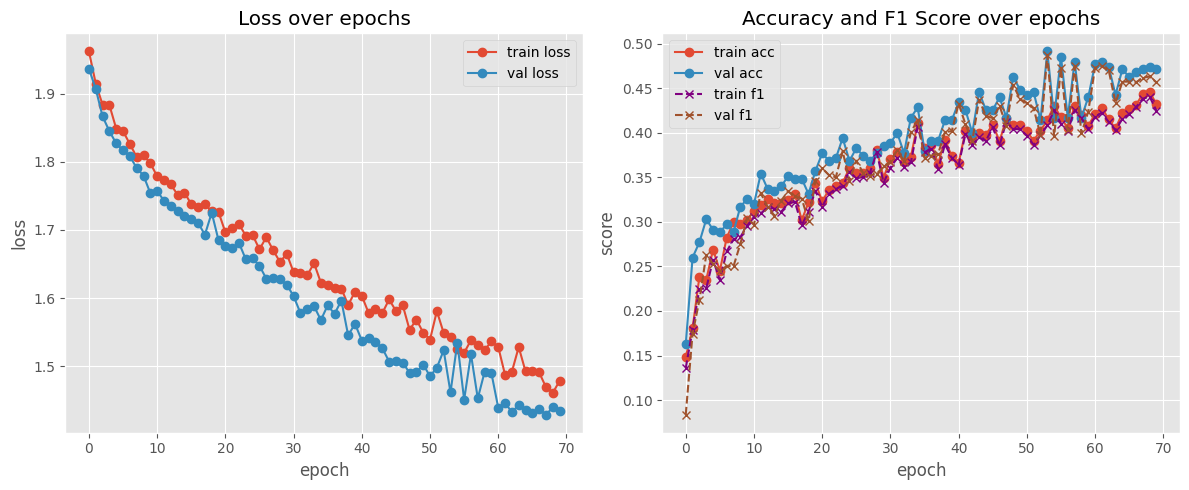

In [ ]:
metrics_demonstration(train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s)

**Conclusions:**

This combination of model architecture features alongside the hyperparameters set manually. With a set learning rate scheduler we achieved to avoid early stopping which was our main problem in the beginning. Therefore, we obtained a trained model for 70 epochs. The model has shown an observable progress: the validation loss has decreased *1.936359961827596 ---> 1.4351485172907512* while the validation accuracy has grown *0.16285714507102966 ---> 0.4714285433292389*. In terms of this task we also utilised the F1 score, and this metric has demonstrated an increase as well: *0.08368334174156189 ---> 0.45661139488220215*.

From the train/validation loss curve we do not see any suspicious pattern. The loss reduces gradually and it does so for both train and validation data. However, for late epochs it can be seen that the spikes appear. Even though they are rather small, it still produces oscillations in the learning algorithm, which could influence the training process in a negative way by making it less stable.

As for the accuracy/f1 metrics plot, in the beginning they are growing steadily. Again, in the late iterations, with the trainin becoming more unstable, the graph looks sharply, and this indicates the present oscillations.

The model's overall performance is not acceptible as the metrics values are even less than from Random Classifier (< 50%). But considering the progress that model has made throughout all passed epochs, it has maken a great progress improving the metrics and lowering the loss without any under- or overfitting patterns. It may be a sensible decision to try changes in model's architecture or increase the number of training epochs, as additional data augmentations did not contribute much to enhancing the model.



## **Part 3:** Hyperparameters Optimization

#### We have chosen the **Optuna** framework to perform hyperparameters optimization

In [ ]:
!pip install -q optuna
import optuna

#### Then we needed to re-define our Basic CNN model to handle dynamics in the layers initialization

In [ ]:
class DynamicBasicCNN(nn.Module):
  """
  Basic CNN which can be constructed dynamically.
  """
  def __init__(self, conv_channels, conv_dropout=0.2, fc_dropout=0.5, num_classes=7):
    super(DynamicBasicCNN, self).__init__()
    c1, c2, c3 = conv_channels

    self.conv1 = nn.Conv2d(3, c1, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(c1)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(c1, c2, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(c2)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(c2, c3, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(c3)
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(2, 2)


    self.conv_dropout = nn.Dropout2d(conv_dropout)
    self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    self.fc1 = nn.Linear(c3, 128)
    self.fc_dropout = nn.Dropout(fc_dropout)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.maxpool1(self.relu1(self.bn1(self.conv1(x))))
    x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
    x = self.maxpool3(self.relu3(self.bn3(self.conv3(x))))

    x = self.conv_dropout(x)
    x = self.global_avg_pool(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc_dropout(x)
    x = self.fc2(x)

    return x

In [ ]:
def objective(trial):
  """
  An objective function in accordance to the logic for work with Optuna module.
  """
  conv_channels = [
      trial.suggest_categorical('c1', [32, 64, 128]),
      trial.suggest_categorical('c2', [64, 128, 256]),
      trial.suggest_categorical('c3', [128, 256, 512]),
  ]

  conv_dropout = trial.suggest_float('conv_dropout', 0.1, 0.4)
  fc_dropout = trial.suggest_float('fc_dropout', 0.3, 0.5)

  weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

  model = DynamicBasicCNN(conv_channels, conv_dropout, fc_dropout).to(device)
  optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=weight_decay)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  train_f1s, val_f1s = [], []

  for epoch in tqdm(range(10)):
    train_loss, train_acc, train_f1, lr = train(model, train_loader, criterion, optimizer, scheduler, device, num_classes=7)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)

    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device, num_classes=7)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)


    trial.report(val_acc, epoch)
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  trial.set_user_attr('train_losses', train_losses)
  trial.set_user_attr('train_accs', train_accs)
  trial.set_user_attr('train_f1s', train_f1s)

  trial.set_user_attr('val_losses', val_losses)
  trial.set_user_attr('val_accs', val_accs)
  trial.set_user_attr('val_f1s', val_f1s)


  return val_accs[-1]

#### Training and validation process of 30 models using Optuna

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_trial = study.best_trial

print('The best val accuracy:', best_trial.value)
print('The best hyperparameters:')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')

[I 2025-04-16 07:32:40,444] A new study created in memory with name: no-name-ce499f65-bdcd-4ca5-b8a7-11e53de1d35a
100%|██████████| 10/10 [01:40<00:00, 10.05s/it]
[I 2025-04-16 07:34:20,976] Trial 0 finished with value: 0.3085714280605316 and parameters: {'c1': 64, 'c2': 256, 'c3': 512, 'conv_dropout': 0.3033262596029608, 'fc_dropout': 0.4355354256899137, 'weight_decay': 0.00017873615054067032}. Best is trial 0 with value: 0.3085714280605316.
100%|██████████| 10/10 [01:29<00:00,  8.98s/it]
[I 2025-04-16 07:35:50,792] Trial 1 finished with value: 0.3199999928474426 and parameters: {'c1': 32, 'c2': 64, 'c3': 256, 'conv_dropout': 0.2482047304569625, 'fc_dropout': 0.44393201773741564, 'weight_decay': 3.7839353882285574e-06}. Best is trial 1 with value: 0.3199999928474426.
100%|██████████| 10/10 [01:38<00:00,  9.88s/it]
[I 2025-04-16 07:37:29,571] Trial 2 finished with value: 0.3285714387893677 and parameters: {'c1': 32, 'c2': 256, 'c3': 512, 'conv_dropout': 0.12033532551065357, 'fc_dropout'

The best val accuracy: 0.36571431159973145
The best hyperparameters:
c1: 128
c2: 256
c3: 512
conv_dropout: 0.3020938225082468
fc_dropout: 0.33283421589904505
weight_decay: 5.334887799865184e-05


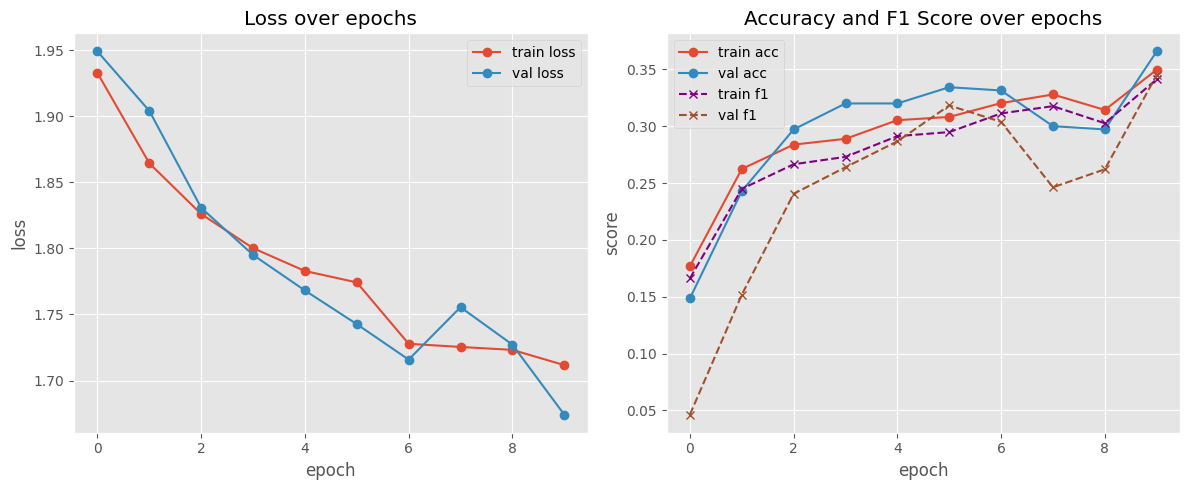

In [ ]:
metrics_demonstration(
    best_trial.user_attrs['train_losses'],
    best_trial.user_attrs['val_losses'],
    best_trial.user_attrs['train_accs'],
    best_trial.user_attrs['val_accs'],
    best_trial.user_attrs['train_f1s'],
    best_trial.user_attrs['val_f1s']
)

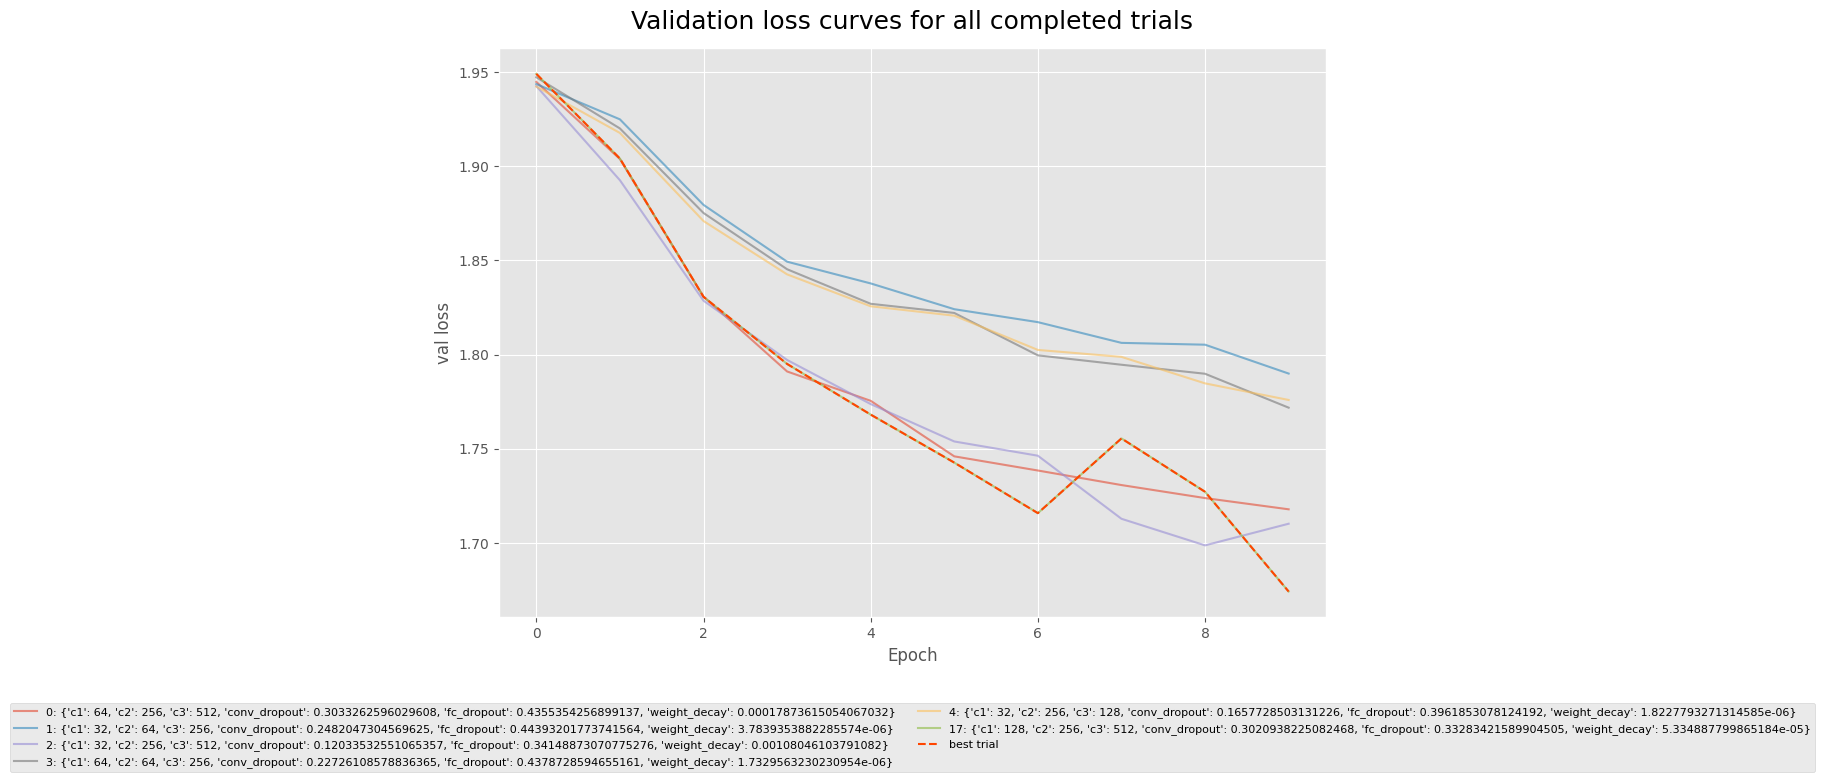

In [ ]:
plt.figure(figsize=(15, 8))

for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        val_losses = trial.user_attrs.get('val_losses', None)
        if val_losses:
            label = f"{trial.number}: {trial.params}"
            plt.plot(val_losses, alpha=0.6, label=label)

best_val_losses = best_trial.user_attrs['val_losses']
plt.plot(best_val_losses, linestyle='dashed', label='best trial', color='orangered')

plt.xlabel('Epoch')
plt.ylabel('val loss')
plt.suptitle('Validation loss curves for all completed trials', fontsize=18)

plt.legend(
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    borderaxespad=0.,
    fontsize=8,
    ncol=2
)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Optuna Visualisation
If the plot is not visible on GitHub, please look at the photo of it in this repo

In [ ]:
optuna_fig = optuna.visualization.plot_param_importances(study)
optuna_fig.show()

**Conclusions:**

Optuna module helped us to see which parameters contribute the most to model's performance. Also, we tried 30 model runs to obtain the list of the most optimal parameters. Only 6 out of 30 models were trained till the end without early pruning.

#### Train our CNN model with chosen hyperparameters for 60 epochs

In [ ]:
dynamic_cnn_model = DynamicBasicCNN([125, 256, 512], 0.3020938225082468, 0.33283421589904505).to(device)
dynamic_cnn_optimizer = optim.AdamW(dynamic_cnn_model.parameters(), lr=1e-4, weight_decay=5.334887799865184e-05)
dynamic_cnn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(dynamic_cnn_optimizer, mode='min', factor=0.5, patience=3)
dynamic_cnn_criterion = nn.CrossEntropyLoss()

dynamic_cnn_save_path = os.path.join(models_dir, 'dynamic_cnn_best.pth')

d_train_losses, d_val_losses, d_train_accs, d_val_accs, d_train_f1s, d_val_f1s = train_and_eval(dynamic_cnn_model,
                                                                                    train_loader,
                                                                                    val_loader,
                                                                                    dynamic_cnn_criterion,
                                                                                    dynamic_cnn_optimizer,
                                                                                    dynamic_cnn_scheduler,
                                                                                    device,
                                                                                    num_epochs=60,
                                                                                    save_path=dynamic_cnn_save_path)

Training:   2%|▏         | 1/60 [00:12<11:59, 12.20s/it]


Epoch:   1/60, lr: 0.000100, train loss: 1.9076632181803386, val loss: 1.950295090675354
train acc: 0.19935424625873566, val acc: 0.16857142746448517
train f1: 0.18959343433380127, val f1: 0.07488569617271423
val loss decreased: inf ---> 1.950295090675354


Training:   3%|▎         | 2/60 [00:22<10:29, 10.86s/it]


Epoch:   2/60, lr: 0.000100, train loss: 1.8637349685033162, val loss: 1.9048130512237549
train acc: 0.25277918577194214, val acc: 0.21714285016059875
train f1: 0.23485249280929565, val f1: 0.12317459285259247
val loss decreased: 1.950295090675354 ---> 1.9048130512237549


Training:   5%|▌         | 3/60 [00:33<10:35, 11.14s/it]


Epoch:   3/60, lr: 0.000100, train loss: 1.8350132942199706, val loss: 1.8351085980733235
train acc: 0.27935972809791565, val acc: 0.26571428775787354
train f1: 0.2619205117225647, val f1: 0.21396735310554504
val loss decreased: 1.9048130512237549 ---> 1.8351085980733235


Training:   7%|▋         | 4/60 [00:44<10:27, 11.21s/it]


Epoch:   4/60, lr: 0.000100, train loss: 1.8068511486053467, val loss: 1.8015616337458293
train acc: 0.2780517637729645, val acc: 0.2799999713897705
train f1: 0.2637883722782135, val f1: 0.21904608607292175
val loss decreased: 1.8351085980733235 ---> 1.8015616337458293


Training:   8%|▊         | 5/60 [00:56<10:15, 11.19s/it]


Epoch:   5/60, lr: 0.000100, train loss: 1.756576943397522, val loss: 1.7499354283014934
train acc: 0.3137221932411194, val acc: 0.3085714280605316
train f1: 0.30062150955200195, val f1: 0.27248841524124146
val loss decreased: 1.8015616337458293 ---> 1.7499354283014934


Training:  10%|█         | 6/60 [01:05<09:37, 10.70s/it]


Epoch:   6/60, lr: 0.000100, train loss: 1.7489962577819824, val loss: 1.7545867760976155
train acc: 0.34905755519866943, val acc: 0.28857141733169556
train f1: 0.3378639817237854, val f1: 0.239324688911438


Training:  12%|█▏        | 7/60 [01:16<09:35, 10.85s/it]


Epoch:   7/60, lr: 0.000100, train loss: 1.736831545829773, val loss: 1.7188109556833904
train acc: 0.3079608678817749, val acc: 0.3285714387893677
train f1: 0.2945150136947632, val f1: 0.3026648759841919
val loss decreased: 1.7499354283014934 ---> 1.7188109556833904


Training:  13%|█▎        | 8/60 [01:28<09:30, 10.97s/it]


Epoch:   8/60, lr: 0.000100, train loss: 1.7348408699035645, val loss: 1.6957463026046753
train acc: 0.3281652331352234, val acc: 0.34285715222358704
train f1: 0.3156842589378357, val f1: 0.3296717405319214
val loss decreased: 1.7188109556833904 ---> 1.6957463026046753


Training:  15%|█▌        | 9/60 [01:39<09:19, 10.98s/it]


Epoch:   9/60, lr: 0.000100, train loss: 1.717971682548523, val loss: 1.6989409526189168
train acc: 0.3411429524421692, val acc: 0.3285714387893677
train f1: 0.33266282081604004, val f1: 0.3003219664096832


Training:  17%|█▋        | 10/60 [01:48<08:49, 10.59s/it]


Epoch:  10/60, lr: 0.000100, train loss: 1.7247896591822307, val loss: 1.693760593732198
train acc: 0.3094513416290283, val acc: 0.331428587436676
train f1: 0.30172601342201233, val f1: 0.30950990319252014
val loss decreased: 1.6957463026046753 ---> 1.693760593732198


Training:  18%|█▊        | 11/60 [02:00<08:48, 10.79s/it]


Epoch:  11/60, lr: 0.000100, train loss: 1.6870245933532715, val loss: 1.6513028144836426
train acc: 0.345529168844223, val acc: 0.3514285683631897
train f1: 0.3374822735786438, val f1: 0.326938271522522
val loss decreased: 1.693760593732198 ---> 1.6513028144836426


Training:  20%|██        | 12/60 [02:11<08:47, 10.99s/it]


Epoch:  12/60, lr: 0.000100, train loss: 1.69449249903361, val loss: 1.6710851987202961
train acc: 0.32967567443847656, val acc: 0.322857141494751
train f1: 0.32068631052970886, val f1: 0.30508777499198914


Training:  22%|██▏       | 13/60 [02:22<08:33, 10.92s/it]


Epoch:  13/60, lr: 0.000100, train loss: 1.6673951784769694, val loss: 1.6627999544143677
train acc: 0.3615361750125885, val acc: 0.36571431159973145
train f1: 0.3538728952407837, val f1: 0.3414168357849121


Training:  23%|██▎       | 14/60 [02:32<08:07, 10.61s/it]


Epoch:  14/60, lr: 0.000100, train loss: 1.6600892623265584, val loss: 1.6250079075495403
train acc: 0.3622923195362091, val acc: 0.3742856979370117
train f1: 0.35480135679244995, val f1: 0.3613976240158081
val loss decreased: 1.6513028144836426 ---> 1.6250079075495403


Training:  25%|██▌       | 15/60 [02:43<08:08, 10.86s/it]


Epoch:  15/60, lr: 0.000100, train loss: 1.6507659832636514, val loss: 1.6846219301223755
train acc: 0.3415991961956024, val acc: 0.331428587436676
train f1: 0.3383147418498993, val f1: 0.3033682703971863


Training:  27%|██▋       | 16/60 [02:54<08:01, 10.94s/it]


Epoch:  16/60, lr: 0.000100, train loss: 1.647774863243103, val loss: 1.6481889883677165
train acc: 0.355506956577301, val acc: 0.3571428656578064
train f1: 0.34907466173171997, val f1: 0.33342957496643066


Training:  28%|██▊       | 17/60 [03:05<07:50, 10.95s/it]


Epoch:  17/60, lr: 0.000100, train loss: 1.6500572999318441, val loss: 1.5925538539886475
train acc: 0.36504417657852173, val acc: 0.4057142734527588
train f1: 0.35926520824432373, val f1: 0.3959478735923767
val loss decreased: 1.6250079075495403 ---> 1.5925538539886475


Training:  30%|███       | 18/60 [03:15<07:27, 10.67s/it]


Epoch:  18/60, lr: 0.000100, train loss: 1.6252110163370768, val loss: 1.6512964963912964
train acc: 0.39106759428977966, val acc: 0.3799999952316284
train f1: 0.3823356032371521, val f1: 0.35810261964797974


Training:  32%|███▏      | 19/60 [03:27<07:26, 10.89s/it]


Epoch:  19/60, lr: 0.000100, train loss: 1.616649611790975, val loss: 1.6336859862009685
train acc: 0.3711380064487457, val acc: 0.368571400642395
train f1: 0.3660867214202881, val f1: 0.3449125289916992


Training:  33%|███▎      | 20/60 [03:38<07:21, 11.03s/it]


Epoch:  20/60, lr: 0.000100, train loss: 1.6045078754425048, val loss: 1.551502267519633
train acc: 0.38125574588775635, val acc: 0.3999999761581421
train f1: 0.37732994556427, val f1: 0.38873356580734253
val loss decreased: 1.5925538539886475 ---> 1.551502267519633


Training:  35%|███▌      | 21/60 [03:48<07:02, 10.85s/it]


Epoch:  21/60, lr: 0.000100, train loss: 1.604575220743815, val loss: 1.5842753251393635
train acc: 0.3818189799785614, val acc: 0.3857142925262451
train f1: 0.3794373571872711, val f1: 0.3756561875343323


Training:  37%|███▋      | 22/60 [03:59<06:48, 10.75s/it]


Epoch:  22/60, lr: 0.000100, train loss: 1.615973671277364, val loss: 1.56067955493927
train acc: 0.3711256682872772, val acc: 0.38857144117355347
train f1: 0.36573076248168945, val f1: 0.3732113838195801


Training:  38%|███▊      | 23/60 [04:10<06:44, 10.92s/it]


Epoch:  23/60, lr: 0.000100, train loss: 1.6005182186762492, val loss: 1.6281177600224812
train acc: 0.3700966536998749, val acc: 0.34285712242126465
train f1: 0.3663032650947571, val f1: 0.3067390024662018


Training:  40%|████      | 24/60 [04:21<06:35, 10.99s/it]


Epoch:  24/60, lr: 0.000100, train loss: 1.5701359113057454, val loss: 1.577546199162801
train acc: 0.39310669898986816, val acc: 0.37714284658432007
train f1: 0.38699638843536377, val f1: 0.3561096787452698


Training:  42%|████▏     | 25/60 [04:32<06:15, 10.73s/it]


Epoch:  25/60, lr: 0.000100, train loss: 1.5517270803451537, val loss: 1.5850718816121419
train acc: 0.41132715344429016, val acc: 0.3514285683631897
train f1: 0.406932532787323, val f1: 0.3188154101371765


Training:  43%|████▎     | 26/60 [04:43<06:07, 10.82s/it]


Epoch:  26/60, lr: 0.000100, train loss: 1.558974313735962, val loss: 1.5226818720499675
train acc: 0.4002200961112976, val acc: 0.41428568959236145
train f1: 0.3950052857398987, val f1: 0.4067413806915283
val loss decreased: 1.551502267519633 ---> 1.5226818720499675


Training:  45%|████▌     | 27/60 [04:54<06:03, 11.01s/it]


Epoch:  27/60, lr: 0.000100, train loss: 1.5644904851913453, val loss: 1.5416984558105469
train acc: 0.41131627559661865, val acc: 0.39714282751083374
train f1: 0.40398067235946655, val f1: 0.38466161489486694


Training:  47%|████▋     | 28/60 [05:05<05:54, 11.07s/it]


Epoch:  28/60, lr: 0.000100, train loss: 1.5352516810099284, val loss: 1.5063381989796956
train acc: 0.4188595414161682, val acc: 0.4285714328289032
train f1: 0.4168773889541626, val f1: 0.4169420301914215
val loss decreased: 1.5226818720499675 ---> 1.5063381989796956


Training:  48%|████▊     | 29/60 [05:16<05:39, 10.96s/it]


Epoch:  29/60, lr: 0.000100, train loss: 1.5359785159428914, val loss: 1.50123397509257
train acc: 0.41042959690093994, val acc: 0.4228571355342865
train f1: 0.4046037495136261, val f1: 0.41525548696517944
val loss decreased: 1.5063381989796956 ---> 1.50123397509257


Training:  50%|█████     | 30/60 [05:26<05:22, 10.76s/it]


Epoch:  30/60, lr: 0.000100, train loss: 1.5254732211430868, val loss: 1.4685776631037395
train acc: 0.42200103402137756, val acc: 0.46000000834465027
train f1: 0.41904568672180176, val f1: 0.458190381526947
val loss decreased: 1.50123397509257 ---> 1.4685776631037395


Training:  52%|█████▏    | 31/60 [05:38<05:16, 10.91s/it]


Epoch:  31/60, lr: 0.000100, train loss: 1.5157600879669189, val loss: 1.5751262108484905
train acc: 0.41998863220214844, val acc: 0.4057143032550812
train f1: 0.41826242208480835, val f1: 0.391399621963501


Training:  53%|█████▎    | 32/60 [05:49<05:06, 10.94s/it]


Epoch:  32/60, lr: 0.000100, train loss: 1.5326162179311116, val loss: 1.5090132157007854
train acc: 0.3964751362800598, val acc: 0.4000000059604645
train f1: 0.3918730616569519, val f1: 0.379109650850296


Training:  55%|█████▌    | 33/60 [05:59<04:48, 10.67s/it]


Epoch:  33/60, lr: 0.000100, train loss: 1.5180056889851887, val loss: 1.5697859525680542
train acc: 0.43133896589279175, val acc: 0.4228571355342865
train f1: 0.42419660091400146, val f1: 0.39440351724624634


Training:  57%|█████▋    | 34/60 [06:09<04:37, 10.67s/it]


Epoch:  34/60, lr: 0.000100, train loss: 1.497444486618042, val loss: 1.4700302282969158
train acc: 0.44174474477767944, val acc: 0.4571428596973419
train f1: 0.44051772356033325, val f1: 0.4522162079811096


Training:  58%|█████▊    | 35/60 [06:20<04:29, 10.76s/it]


Epoch:  35/60, lr: 0.000100, train loss: 1.5435304005940755, val loss: 1.4672650893529255
train acc: 0.4221506118774414, val acc: 0.43142855167388916
train f1: 0.41800379753112793, val f1: 0.42560601234436035
val loss decreased: 1.4685776631037395 ---> 1.4672650893529255


Training:  60%|██████    | 36/60 [06:31<04:21, 10.90s/it]


Epoch:  36/60, lr: 0.000100, train loss: 1.4920254468917846, val loss: 1.570267677307129
train acc: 0.4407607316970825, val acc: 0.3914285898208618
train f1: 0.43917980790138245, val f1: 0.37880221009254456


Training:  62%|██████▏   | 37/60 [06:42<04:05, 10.66s/it]


Epoch:  37/60, lr: 0.000100, train loss: 1.4625149806340536, val loss: 1.5370637973149617
train acc: 0.4487748444080353, val acc: 0.4171428680419922
train f1: 0.4454277455806732, val f1: 0.40215492248535156


Training:  63%|██████▎   | 38/60 [06:52<03:56, 10.74s/it]


Epoch:  38/60, lr: 0.000100, train loss: 1.4402721405029297, val loss: 1.5604224999745686
train acc: 0.46115195751190186, val acc: 0.38285714387893677
train f1: 0.45907682180404663, val f1: 0.35599491000175476


Training:  65%|██████▌   | 39/60 [07:04<03:49, 10.91s/it]


Epoch:  39/60, lr: 0.000100, train loss: 1.4721710761388143, val loss: 1.433039943377177
train acc: 0.46450990438461304, val acc: 0.4828571379184723
train f1: 0.45937228202819824, val f1: 0.48078370094299316
val loss decreased: 1.4672650893529255 ---> 1.433039943377177


Training:  67%|██████▋   | 40/60 [07:15<03:40, 11.01s/it]


Epoch:  40/60, lr: 0.000100, train loss: 1.4519787788391114, val loss: 1.4647798538208008
train acc: 0.4570331573486328, val acc: 0.45428574085235596
train f1: 0.4540548622608185, val f1: 0.4386037290096283


Training:  68%|██████▊   | 41/60 [07:25<03:22, 10.66s/it]


Epoch:  41/60, lr: 0.000100, train loss: 1.4580942153930665, val loss: 1.4888256788253784
train acc: 0.467853307723999, val acc: 0.4457142949104309
train f1: 0.46502986550331116, val f1: 0.44170305132865906


Training:  70%|███████   | 42/60 [07:36<03:13, 10.73s/it]


Epoch:  42/60, lr: 0.000050, train loss: 1.4543553034464518, val loss: 1.4128659963607788
train acc: 0.4793727993965149, val acc: 0.4657142758369446
train f1: 0.47802621126174927, val f1: 0.46191927790641785
val loss decreased: 1.433039943377177 ---> 1.4128659963607788


Training:  72%|███████▏  | 43/60 [07:47<03:06, 10.94s/it]


Epoch:  43/60, lr: 0.000050, train loss: 1.4204323450724283, val loss: 1.4228295882542927
train acc: 0.47306028008461, val acc: 0.4342857003211975
train f1: 0.4705323576927185, val f1: 0.42184966802597046


Training:  73%|███████▎  | 44/60 [07:58<02:56, 11.03s/it]


Epoch:  44/60, lr: 0.000050, train loss: 1.4221650123596192, val loss: 1.3817819356918335
train acc: 0.4583827257156372, val acc: 0.4885714650154114
train f1: 0.4563313126564026, val f1: 0.4860146641731262
val loss decreased: 1.4128659963607788 ---> 1.3817819356918335


Training:  75%|███████▌  | 45/60 [08:08<02:39, 10.66s/it]


Epoch:  45/60, lr: 0.000050, train loss: 1.425711727142334, val loss: 1.421218713124593
train acc: 0.4362523853778839, val acc: 0.477142870426178
train f1: 0.4342261850833893, val f1: 0.47562849521636963


Training:  77%|███████▋  | 46/60 [08:19<02:30, 10.77s/it]


Epoch:  46/60, lr: 0.000050, train loss: 1.3933169364929199, val loss: 1.3660177787144978
train acc: 0.47629672288894653, val acc: 0.5057142972946167
train f1: 0.4737357199192047, val f1: 0.498393714427948
val loss decreased: 1.3817819356918335 ---> 1.3660177787144978


Training:  78%|███████▊  | 47/60 [08:30<02:21, 10.89s/it]


Epoch:  47/60, lr: 0.000050, train loss: 1.4065982739130656, val loss: 1.4092120726903279
train acc: 0.4678916335105896, val acc: 0.4771428406238556
train f1: 0.46527552604675293, val f1: 0.47042539715766907


Training:  80%|████████  | 48/60 [08:41<02:10, 10.90s/it]


Epoch:  48/60, lr: 0.000050, train loss: 1.4108137687047322, val loss: 1.3954124450683594
train acc: 0.4783855676651001, val acc: 0.48000001907348633
train f1: 0.47566109895706177, val f1: 0.4734557569026947


Training:  82%|████████▏ | 49/60 [08:51<01:55, 10.51s/it]


Epoch:  49/60, lr: 0.000050, train loss: 1.378282896677653, val loss: 1.3615566889444988
train acc: 0.4963383674621582, val acc: 0.49142855405807495
train f1: 0.4932996332645416, val f1: 0.48851466178894043
val loss decreased: 1.3660177787144978 ---> 1.3615566889444988


Training:  83%|████████▎ | 50/60 [09:02<01:46, 10.69s/it]


Epoch:  50/60, lr: 0.000050, train loss: 1.4091122945149739, val loss: 1.3712475697199504
train acc: 0.48383083939552307, val acc: 0.5057142972946167
train f1: 0.48107537627220154, val f1: 0.500865638256073


Training:  85%|████████▌ | 51/60 [09:14<01:38, 10.91s/it]


Epoch:  51/60, lr: 0.000050, train loss: 1.3964502175649007, val loss: 1.380906303723653
train acc: 0.49442389607429504, val acc: 0.4714285731315613
train f1: 0.4928825795650482, val f1: 0.464993417263031


Training:  87%|████████▋ | 52/60 [09:24<01:26, 10.85s/it]


Epoch:  52/60, lr: 0.000050, train loss: 1.3955504655838014, val loss: 1.3923139174779255
train acc: 0.4708606004714966, val acc: 0.47999998927116394
train f1: 0.4689704179763794, val f1: 0.4686647057533264


Training:  88%|████████▊ | 53/60 [09:34<01:13, 10.52s/it]


Epoch:  53/60, lr: 0.000050, train loss: 1.3751547416051229, val loss: 1.3749711513519287
train acc: 0.4823671579360962, val acc: 0.5171428322792053
train f1: 0.47840404510498047, val f1: 0.5084558725357056


Training:  90%|█████████ | 54/60 [09:45<01:04, 10.81s/it]


Epoch:  54/60, lr: 0.000050, train loss: 1.36009521484375, val loss: 1.3777337869008381
train acc: 0.494076132774353, val acc: 0.4599999785423279
train f1: 0.49136611819267273, val f1: 0.4552602171897888


Training:  92%|█████████▏| 55/60 [09:57<00:54, 10.94s/it]


Epoch:  55/60, lr: 0.000050, train loss: 1.3865896145502725, val loss: 1.3530640204747517
train acc: 0.47831660509109497, val acc: 0.5257142782211304
train f1: 0.4771893620491028, val f1: 0.5200926661491394
val loss decreased: 1.3615566889444988 ---> 1.3530640204747517


Training:  93%|█████████▎| 56/60 [10:07<00:43, 10.85s/it]


Epoch:  56/60, lr: 0.000050, train loss: 1.3767348686854044, val loss: 1.4101111094156902
train acc: 0.47801607847213745, val acc: 0.49142858386039734
train f1: 0.47557657957077026, val f1: 0.485688179731369


Training:  95%|█████████▌| 57/60 [10:18<00:31, 10.64s/it]


Epoch:  57/60, lr: 0.000050, train loss: 1.3600032011667886, val loss: 1.3711849451065063
train acc: 0.477350115776062, val acc: 0.49142858386039734
train f1: 0.47306326031684875, val f1: 0.48561573028564453


Training:  97%|█████████▋| 58/60 [10:29<00:21, 10.81s/it]


Epoch:  58/60, lr: 0.000025, train loss: 1.4009227355321248, val loss: 1.3476078907648723
train acc: 0.4764387011528015, val acc: 0.4942857027053833
train f1: 0.4731800854206085, val f1: 0.49548953771591187
val loss decreased: 1.3530640204747517 ---> 1.3476078907648723


Training:  98%|█████████▊| 59/60 [10:40<00:10, 10.93s/it]


Epoch:  59/60, lr: 0.000025, train loss: 1.387728230158488, val loss: 1.3892508745193481
train acc: 0.48315244913101196, val acc: 0.485714316368103
train f1: 0.4820770025253296, val f1: 0.48190826177597046


Training: 100%|██████████| 60/60 [10:51<00:00, 10.86s/it]


Epoch:  60/60, lr: 0.000025, train loss: 1.3512689034144083, val loss: 1.3415926694869995
train acc: 0.49851036071777344, val acc: 0.5057142972946167
train f1: 0.49497002363204956, val f1: 0.4990335702896118
val loss decreased: 1.3476078907648723 ---> 1.3415926694869995


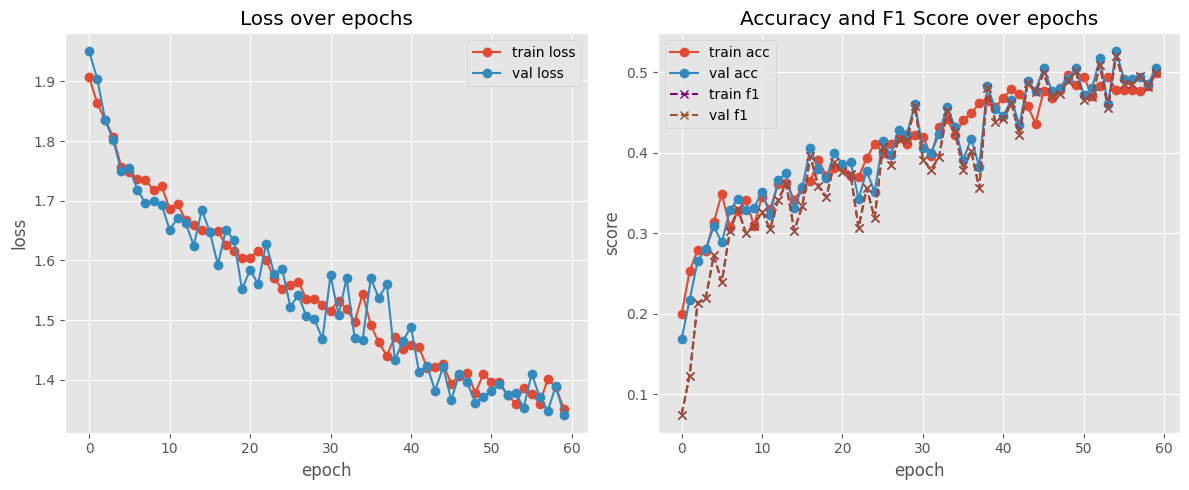

In [ ]:
metrics_demonstration(d_train_losses, d_val_losses, d_train_accs, d_val_accs, d_val_f1s, d_val_f1s)

In [ ]:
dyn_cnn_preds = []
dyn_cnn_labels = []

dynamic_cnn_model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = dynamic_cnn_model(inputs)
    preds = outputs.argmax(1)
    dyn_cnn_preds.extend(preds.cpu().numpy())
    dyn_cnn_labels.extend(labels.cpu().numpy())

print(classification_report(dyn_cnn_labels, dyn_cnn_preds))

              precision    recall  f1-score   support

           0       0.33      0.47      0.39        15
           1       0.50      0.31      0.38        16
           2       0.53      0.47      0.50        17
           3       0.46      0.35      0.40        17
           4       0.44      0.88      0.58         8
           5       0.64      0.50      0.56        18
           6       0.50      0.57      0.53        14

    accuracy                           0.48       105
   macro avg       0.49      0.51      0.48       105
weighted avg       0.50      0.48      0.47       105



**Conclusions:**

We used the list of best parameters, obtained in the previous step, to fit a new model. It was training successfully for 60 epochs without early stopping. The best parameters are listed below:

*{'c1': 128, 'c2': 256, 'c3': 512, 'conv_dropout': 0.3020938225082468, 'fc_dropout': 0.33283421589904505, 'weight_decay': 5.334887799865184e-05}*.

In general, this model performed better than the one before. The training process looks more stable which can be seen from train/validation curves. The values of accuracy and f1 increased, as well. Model's performance is still not acceptable, but it showed some progress, which indicates there is a space for improvement as model understands this data overall.

We performed the evaluation on the test subset for this model and got a classification report. The best results have been obtained for classes *4(ramen)*, *5(sushi)*, *6(tiramisu)*, and the worst one for *1(apple_pie)*.

The macro and weighted average accuracy values are similar to each other.


## **Part 4:** Transfer Learning

#### For the transfer learning part, we have chosen a **ResNet** architecture

In [ ]:
resnet_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet_model.parameters():
  param.requires_grad = False

#### Add an MLP as a top layer
* Linear model
* Original ReLU activation
* Dropout of 0.4 to prevent overfitting

In [ ]:
resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

In [ ]:
def defrost_layers(model, num_unfreeze_blocks):
  """
  Defrosts a specified number of hidden layers of a given model.
  """
  layer_blocks = [
      model.layer4,
      model.layer3,
      model.layer2,
      model.layer1
  ]

  for i, layer in enumerate(layer_blocks[:num_unfreeze_blocks]):
      for param in layer.parameters():
          param.requires_grad = True

#### Defrost the upper layers of the model using the pre-defined function, and train these layers on our data for 30 epochs

In [ ]:
resnet_model_optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=1e-4, weight_decay=1e-4)
resnet_model_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet_model_optimizer, mode='min', factor=0.5, patience=3)
resnet_model_criterion = nn.CrossEntropyLoss()
resnet_model.to(device)
rn_train_losses, rn_val_losses = [], []
rn_train_accs, rn_val_accs = [], []
rn_train_f1s, rn_val_f1s = [], []
for epoch in tqdm(range(30), desc='ResNet50 Fine-tuning'):
  defrost_layers(resnet_model, min(epoch+1, 4))
  rn_train_loss, rn_train_acc, rn_train_f1, _ = train(resnet_model, train_loader, resnet_model_criterion, resnet_model_optimizer, resnet_model_scheduler, device, num_classes)
  rn_val_loss, rn_val_acc, rn_val_f1 = validate(resnet_model, val_loader, resnet_model_criterion, device, num_classes)

  rn_train_losses.append(rn_train_loss)
  rn_train_accs.append(rn_train_acc)
  rn_train_f1s.append(rn_train_f1)
  rn_val_losses.append(rn_val_loss)
  rn_val_accs.append(rn_val_acc)
  rn_val_f1s.append(rn_val_f1)

  print(f'Epoch {epoch}: val acc: {rn_val_acc}, val F1: {rn_val_f1}')

ResNet50 Fine-tuning:   3%|▎         | 1/30 [00:08<04:11,  8.68s/it]

Epoch 0: val acc: 0.39714282751083374, val F1: 0.37193432450294495


ResNet50 Fine-tuning:   7%|▋         | 2/30 [00:19<04:40, 10.01s/it]

Epoch 1: val acc: 0.5428571701049805, val F1: 0.5227460861206055


ResNet50 Fine-tuning:  10%|█         | 3/30 [00:32<05:09, 11.46s/it]

Epoch 2: val acc: 0.6114286184310913, val F1: 0.5962988138198853


ResNet50 Fine-tuning:  13%|█▎        | 4/30 [00:44<04:55, 11.37s/it]

Epoch 3: val acc: 0.6371428966522217, val F1: 0.6236202716827393


ResNet50 Fine-tuning:  17%|█▋        | 5/30 [00:53<04:30, 10.82s/it]

Epoch 4: val acc: 0.6685714721679688, val F1: 0.657962441444397


ResNet50 Fine-tuning:  20%|██        | 6/30 [01:04<04:20, 10.87s/it]

Epoch 5: val acc: 0.6571428775787354, val F1: 0.6482220888137817


ResNet50 Fine-tuning:  23%|██▎       | 7/30 [01:16<04:13, 11.02s/it]

Epoch 6: val acc: 0.6714285612106323, val F1: 0.6611944437026978


ResNet50 Fine-tuning:  27%|██▋       | 8/30 [01:27<04:03, 11.06s/it]

Epoch 7: val acc: 0.6542856693267822, val F1: 0.6462751626968384


ResNet50 Fine-tuning:  30%|███       | 9/30 [01:37<03:46, 10.78s/it]

Epoch 8: val acc: 0.677142858505249, val F1: 0.6698924899101257


ResNet50 Fine-tuning:  33%|███▎      | 10/30 [01:48<03:38, 10.95s/it]

Epoch 9: val acc: 0.6971428394317627, val F1: 0.6909934878349304


ResNet50 Fine-tuning:  37%|███▋      | 11/30 [02:00<03:29, 11.04s/it]

Epoch 10: val acc: 0.6971428394317627, val F1: 0.6926612854003906


ResNet50 Fine-tuning:  40%|████      | 12/30 [02:13<03:30, 11.67s/it]

Epoch 11: val acc: 0.699999988079071, val F1: 0.6933272480964661


ResNet50 Fine-tuning:  43%|████▎     | 13/30 [02:24<03:14, 11.43s/it]

Epoch 12: val acc: 0.7228571772575378, val F1: 0.7175203561782837


ResNet50 Fine-tuning:  47%|████▋     | 14/30 [02:34<02:56, 11.03s/it]

Epoch 13: val acc: 0.7228571176528931, val F1: 0.7188832759857178


ResNet50 Fine-tuning:  50%|█████     | 15/30 [02:45<02:46, 11.13s/it]

Epoch 14: val acc: 0.7314285635948181, val F1: 0.7263115644454956


ResNet50 Fine-tuning:  53%|█████▎    | 16/30 [02:56<02:35, 11.12s/it]

Epoch 15: val acc: 0.73714280128479, val F1: 0.7317328453063965


ResNet50 Fine-tuning:  57%|█████▋    | 17/30 [03:06<02:21, 10.86s/it]

Epoch 16: val acc: 0.7314285635948181, val F1: 0.7269918918609619


ResNet50 Fine-tuning:  60%|██████    | 18/30 [03:17<02:09, 10.80s/it]

Epoch 17: val acc: 0.7428570985794067, val F1: 0.7390730381011963


ResNet50 Fine-tuning:  63%|██████▎   | 19/30 [03:29<02:02, 11.11s/it]

Epoch 18: val acc: 0.7542856931686401, val F1: 0.7497292757034302


ResNet50 Fine-tuning:  67%|██████▋   | 20/30 [03:40<01:50, 11.09s/it]

Epoch 19: val acc: 0.7628571391105652, val F1: 0.7589112520217896


ResNet50 Fine-tuning:  70%|███████   | 21/30 [03:50<01:36, 10.67s/it]

Epoch 20: val acc: 0.7628571391105652, val F1: 0.7600762844085693


ResNet50 Fine-tuning:  73%|███████▎  | 22/30 [04:00<01:25, 10.72s/it]

Epoch 21: val acc: 0.7685714364051819, val F1: 0.7654979825019836


ResNet50 Fine-tuning:  77%|███████▋  | 23/30 [04:12<01:16, 10.86s/it]

Epoch 22: val acc: 0.7657142877578735, val F1: 0.7627902626991272


ResNet50 Fine-tuning:  80%|████████  | 24/30 [04:23<01:05, 10.92s/it]

Epoch 23: val acc: 0.7742856740951538, val F1: 0.7706717848777771


ResNet50 Fine-tuning:  83%|████████▎ | 25/30 [04:32<00:52, 10.47s/it]

Epoch 24: val acc: 0.7685713768005371, val F1: 0.7664084434509277


ResNet50 Fine-tuning:  87%|████████▋ | 26/30 [04:43<00:42, 10.74s/it]

Epoch 25: val acc: 0.7657142877578735, val F1: 0.7624210715293884


ResNet50 Fine-tuning:  90%|█████████ | 27/30 [04:55<00:32, 10.86s/it]

Epoch 26: val acc: 0.7685713768005371, val F1: 0.7653647661209106


ResNet50 Fine-tuning:  93%|█████████▎| 28/30 [05:06<00:21, 10.87s/it]

Epoch 27: val acc: 0.7742856740951538, val F1: 0.7710525989532471


ResNet50 Fine-tuning:  97%|█████████▋| 29/30 [05:15<00:10, 10.48s/it]

Epoch 28: val acc: 0.7799999713897705, val F1: 0.7773740291595459


ResNet50 Fine-tuning: 100%|██████████| 30/30 [05:26<00:00, 10.89s/it]

Epoch 29: val acc: 0.7742856740951538, val F1: 0.7709373235702515


#### Loss and metrics plots for a fine-tuned model

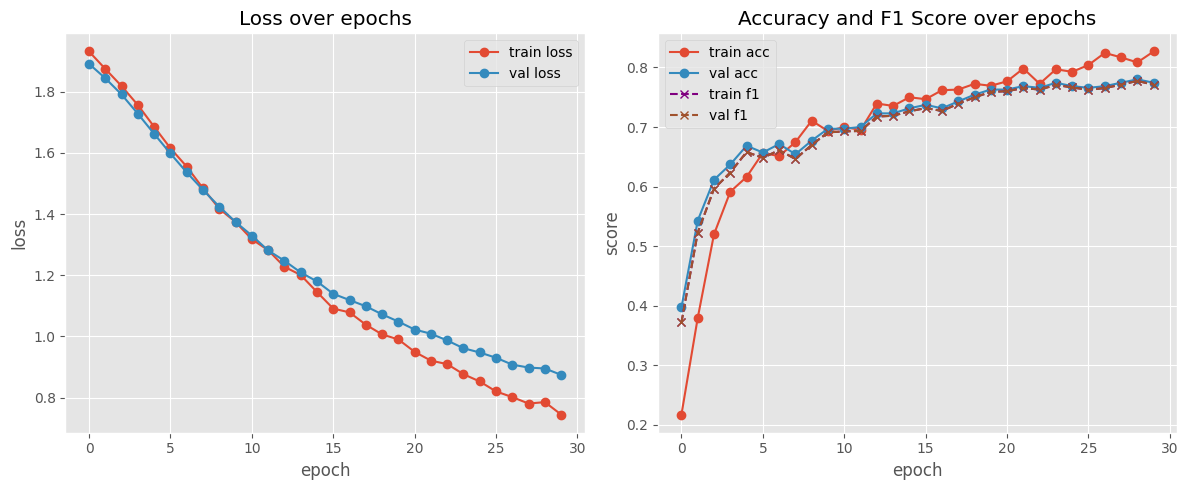

In [ ]:
metrics_demonstration(rn_train_losses, rn_val_losses, rn_train_accs, rn_val_accs, rn_val_f1s, rn_val_f1s)

#### Save the fine-tuned model

In [ ]:
finetuned_resnet = os.path.join(models_dir, 'finetuned_resnet50.pth')
torch.save(resnet_model.state_dict(), finetuned_resnet)

#### Test the fine-tuned model on the test loader

In [ ]:
all_images = []
all_true_labels = []
all_predicted_labels = []

resnet_model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = resnet_model(inputs)
    preds = outputs.argmax(1)
    all_images.extend(inputs.cpu())
    all_true_labels.extend(labels.cpu().numpy())
    all_predicted_labels.extend(preds.cpu().numpy())

print(classification_report(all_true_labels, all_predicted_labels))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52        15
           1       0.91      0.62      0.74        16
           2       0.63      0.71      0.67        17
           3       0.82      0.82      0.82        17
           4       0.89      1.00      0.94         8
           5       0.75      0.83      0.79        18
           6       0.92      0.86      0.89        14

    accuracy                           0.75       105
   macro avg       0.78      0.77      0.77       105
weighted avg       0.76      0.75      0.75       105



#### Get the confusion matrix for the fine-tuned model prediction

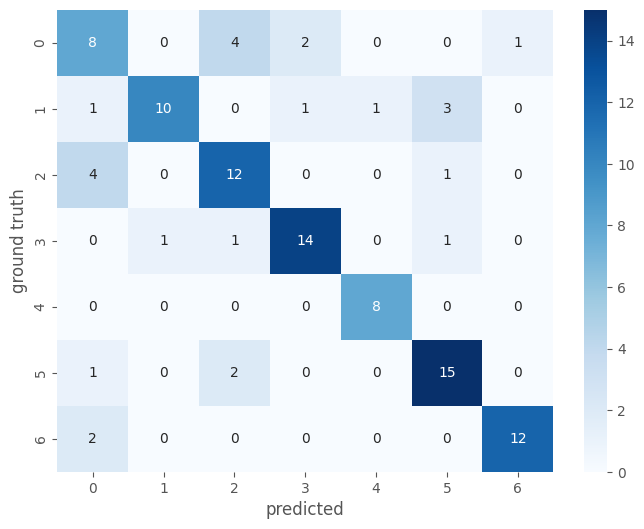

In [ ]:
cm = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('ground truth')
plt.show()

#### Print test images with predicted and actual labels

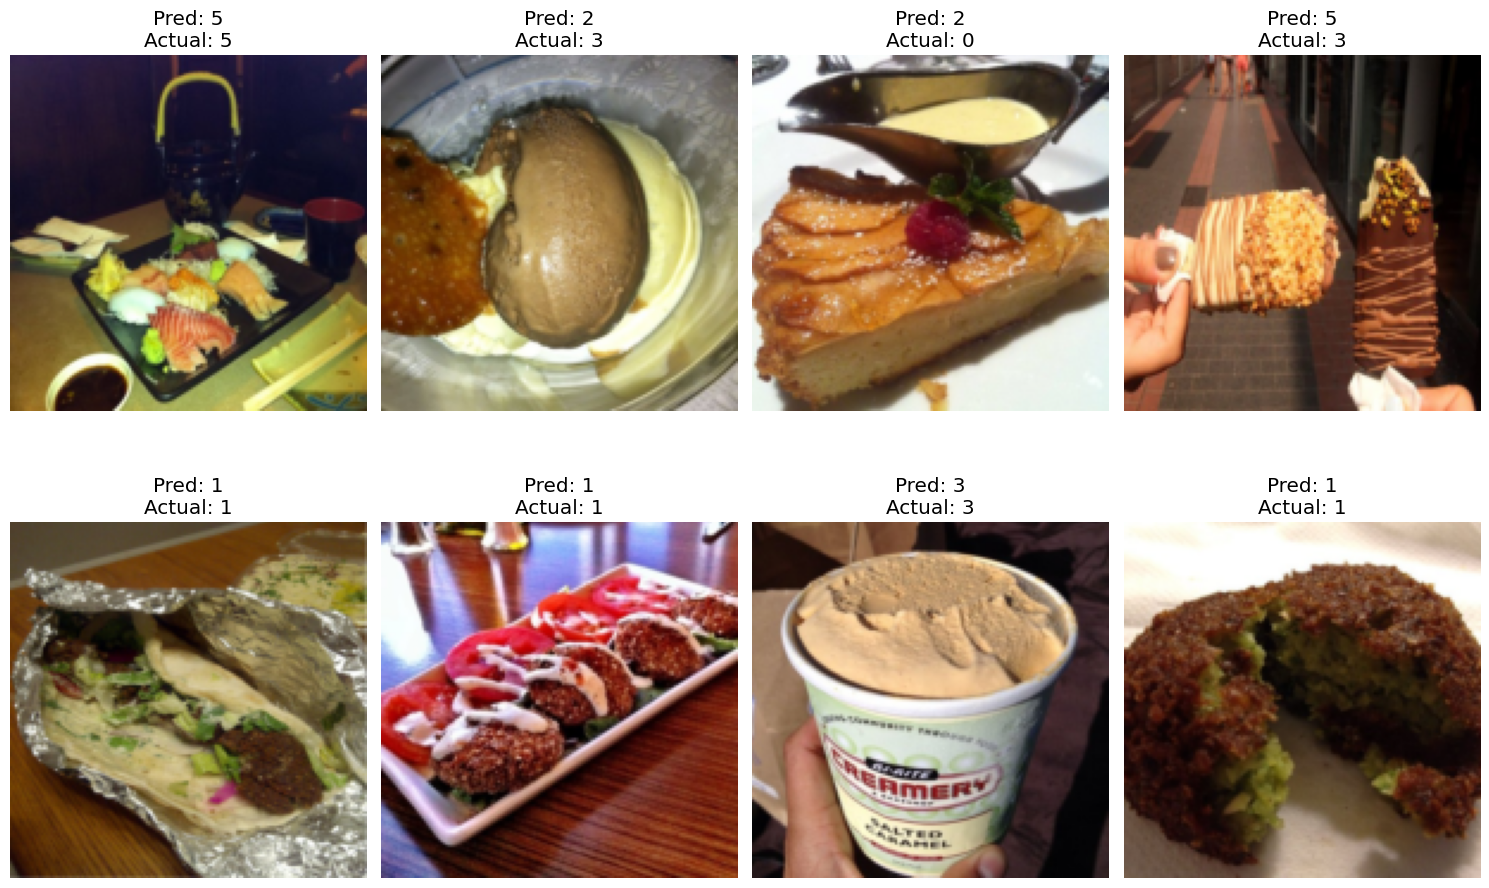

In [ ]:
random.seed(123)
random_indices = random.sample(range(len(all_images)), 8)
plt.figure(figsize=(15, 10))
for idx, img_idx in enumerate(random_indices):
    image = all_images[img_idx].permute(1, 2, 0).numpy()
    true_label = all_true_labels[img_idx]
    predicted_label = all_predicted_labels[img_idx]

    plt.subplot(2, 4, idx + 1)
    plt.imshow((image - image.min()) / (image.max() - image.min()))
    plt.title(f'Pred: {predicted_label}\nActual: {true_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Final Conclusions
In the last part, we performed transfer learning using a ResNet50 backbone. As our original data contained not a large number of images, we trained a simple MLP as a classfier head of the pre-trained model (the specifications for it are mentioned above). In the beginning, we froze all layers and sequentially defroze 4 of them, starting from layer 4 to layer 1. The model was trained for 30 epochs and it has shown moderate results. With a pre-trained backbone, it is eacy to fall into having an overfitting, especially if the training data is small, therefore, the use of Dropout was crucial. Having tried the values of *0.4*, *0.5* and *0.6*, the former one was selected.

The train/validation loss curve goes smoothly in the beginning, but there is a slight pattern of overfitting for the late epochs. The same situation is for the metrics plot, as they begin to create a plateau between 20-30 iterations. In this case, the model may benefit from setting more aggresive augmentations for train and validation data or even using combinations of augmentations for different epochs.

For the final model we performed evaluation on the test subset, and obtained a classification report along with a confusion matrix. There are both well- and underperformed classes. An interesting point is that the class-wise accuracy follows almost the same pattern as our Basic CNN, with class *1* being the least accurate and classes *5* and *6* – the best ones.

We also created a plot with random test images and their predicted VS actual labels. It can be seen that the sweet food is distinguished worse by the model then the "salty".

To improve this model's performance, it may be beneficial to play around the chose of the learning rate and weight decay parameters, as well as try different Dropout rate values to address the overfitting issue.